In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc
from scipy import stats
import sklearn
import seaborn as sns


for file in os.listdir("house-prices-advanced-regression-techniques"):
    print(file)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600


sample_submission.csv
test.csv
train.csv
data_description.txt


In [2]:
data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
data = data.drop(columns = 'Id')
#data.replace({'NA':np.nan},inplace = True)

In [3]:
missing_percent = (data.isna().sum(axis = 0) / len(data))
cols_to_remove = missing_percent[missing_percent > 0].index

In [4]:
## Removing any columns with missing data not previously encoded with NA
missing_percent[missing_percent > 0].index

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [5]:
data = data.drop(columns = cols_to_remove)
print("# columns",len(data.columns))

# columns 61


## Dtypes

Below is an illustritive example of encoding the first column of the data into a categorical variable and then into distinct columns.

The first column is strange, being made up of 15 distinct numeric values that refer to different dwelling types. The levels don't scale linearly between levels, so numeric values may have already been inteligently assigned to the different dwelling types acording to previous knowledge, however there is nothing implicit that says that:

*1-STORY W/FINISHED ATTIC ALL AGES*  --- (40)

is exactly twice that of 

*1-STORY 1946 & NEWER ALL STYLES*    --- (20)

in any sense.


Therefore it will be assigned to a categorical variable and one-hot encoded into 15 distinct columns. The second column is a classic normal categorical variable.

In [6]:
from sklearn.preprocessing import OneHotEncoder

## Encode to category
candid = data[data.columns[0:2]].astype('category')
encoded = OneHotEncoder().fit_transform(candid)

## Each unique value in the column gets converted into it's own
## column indicating the presence / absence of that dwelling type
print(len(candid[candid.columns[0]].unique()))
print(len(candid[candid.columns[1]].unique()))

15
5


In [7]:
## The two columns have been expanded into 20 columns
print(candid.shape)
print(encoded.toarray().shape)

(1460, 2)
(1460, 20)


### Categorical Encodings

Categorical variables have multiple levels for each variable. For this dataset, all levels are 'hopefully' in the original "training" dataset. Appearences of levels in the test set that aren't in the training set may impose some computational error later, however the lack of explainability in the abscence of that level is mathematically simple - nothing can be inferred from that particular variable for that observation.

In [8]:
categorical = ["MSSubClass","MSZoning","Street","LotShape","LandContour",
               "Utilities","LotConfig","LandSlope","Neighborhood",
               "Condition1","Condition2","BldgType","HouseStyle","RoofStyle",
               "RoofMatl","Exterior1st","Exterior2nd",
              "Foundation",
              "Heating","CentralAir",
              "PavedDrive","SaleType","SaleCondition"]

In [9]:
## Automatically set the categories, order is not important
for column in categorical:
    data[column] = data[column].astype('category')

In [10]:
from sklearn.preprocessing import OneHotEncoder

categorical_encoder = OneHotEncoder()
categorical_data = categorical_encoder.fit_transform(data[categorical]).toarray()

In [11]:
print("before",data[categorical].shape)
print("after",categorical_data.shape)

before (1460, 23)
after (1460, 172)


In [12]:
len(categorical_encoder.get_feature_names())

172

In [13]:
encoded_data = pd.DataFrame(categorical_data,columns = categorical_encoder.get_feature_names())

### Ordinal Encodings

Ordinal encodings here are done for variables that are explicitly ordered in their presumed effect upon the outcome variable. 

I.e the variable ExterQual : Evaluates the quality of the material on the exterior, and has 5 levels

{Ex:Excellent,
Gd:Good,
TA:Average/Typical,
Fa:Fair,
Po:Poor}

This can clearly be made into a rating 0-4. However for the variable LandContour, evaluating the flatness of the property, there is a clear order to how steep the gradient of the land is where the property resides, but there isn't a clear indication that the effect between levels will be equal. That is, imposing a euclidean metric to the variable is unsuitable and will likely be sub-optimal for linear regression methods. 

That, and being more stringent on ordinal variables saves a bit of time from not having to define clear orders for each uniquely leveled category.

In [14]:
## Ordinals already in numeric form
prenominal_ordinals = ["OverallQual","OverallCond"]

## Poor to Excellent rating ordinals
poEx_ordinals = ["ExterQual","ExterCond",
                 "HeatingQC", "KitchenQual"]
poEx_levels = ["NA","Po","Fa","TA","Gd","Ex"]
                 
## Functional: Home Functionality (likely important)
func_ordinal = ["Functional"]
func_levels = ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"]

In [15]:
## Need to encode actual np.nans to NA level
## sklearn's OrdinalEncoder (despite seemingly insisting otherwise) doesn't passthrough np.nans
data[poEx_ordinals] = data[poEx_ordinals].fillna('NA')

In [16]:
## Need to specify all levels in the categories argument so that
## all levels are in correct order and have no missing levels
for column in poEx_ordinals:
    data[column] = pd.Categorical(data[column],categories = poEx_levels,ordered = True)
for column in func_ordinal:
    data[column] = pd.Categorical(data[column],categories = func_levels)

In [17]:
data[poEx_ordinals[0]]

0       Gd
1       TA
2       Gd
3       TA
4       Gd
        ..
1455    TA
1456    TA
1457    Ex
1458    TA
1459    Gd
Name: ExterQual, Length: 1460, dtype: category
Categories (6, object): ['NA' < 'Po' < 'Fa' < 'TA' < 'Gd' < 'Ex']

In [18]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = np.nan)
ordinal_data = ord_enc.fit_transform(data[poEx_ordinals + func_ordinal])

In [19]:
ordinal_data

array([[2., 4., 0., 2., 6.],
       [3., 4., 0., 3., 6.],
       [2., 4., 0., 2., 6.],
       ...,
       [0., 2., 0., 2., 6.],
       [3., 4., 2., 2., 6.],
       [2., 4., 2., 3., 6.]])

In [20]:
## Add to dataframe
encoded_data[poEx_ordinals + func_ordinal] = ordinal_data

In [21]:
encoded_data.shape

(1460, 177)

### DateTime
DateTime encoded data is unsuitable for some models and doesn't fit well with scaling, therefore most will be left as generic integer datatypes. The only change here is to change the month of sale and year of sale variables into one column.

In [22]:
## Define Time-of-Sale variable
data['ToS'] = data['YrSold'] + (data['MoSold'] / 12)
data.drop(columns = ['YrSold','MoSold'],inplace = True)

### Add Numeric Data
Final data type is conventional numeric data.

In [23]:
remaining_columns = data.columns.drop(categorical + poEx_ordinals + func_ordinal)
data[remaining_columns].shape

(1460, 32)

In [24]:
## Fill in the remaining numeric and rename as data
encoded_data[remaining_columns] = data[remaining_columns]
data = encoded_data

## Missing Values
Originally, some missing data was set to be interpolated through some scipy method, however as this would be done before training any models it would introduce some normalization bias and data leakage into the training procedure. Therefore this section is empty.

In [25]:
print(len(data))
print(len(data.dropna()))

1460
1460


# Train Test Split
Now need to split the data into different groups of data. With ~1600 data entries, this will be fine to be split into 80% train 20% test.

In [26]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size = 0.2,random_state = 420)
#train.fillna(0,inplace = True),test.fillna(0,inplace = True)

## Remove SalePrice (the response variable), and split into x and y
x_train,y_train = train.drop(columns = 'SalePrice'),train['SalePrice'].to_numpy()
x_test,y_test = test.drop(columns = 'SalePrice'),test['SalePrice'].to_numpy()

In [27]:
y_train

array([127000, 174000, 175900, ..., 119000, 127000, 124900])

In [28]:
## Only scale the previously known numeric data, doesn't make sense for ordinals
scaling_columns = list(remaining_columns) + prenominal_ordinals + poEx_ordinals + func_ordinal
scaling_columns.remove('SalePrice')
x_scaler_numeric = MinMaxScaler().fit(x_train[scaling_columns].to_numpy())
x_train[scaling_columns],x_test[scaling_columns] = x_scaler_numeric.transform(x_train[scaling_columns].to_numpy()),x_scaler_numeric.transform(x_test[scaling_columns].to_numpy())
y_scaler = MinMaxScaler().fit(y_train[:,None])
y_train,y_test = y_scaler.transform(y_train[:,None]),y_scaler.transform(y_test[:,None])

In [29]:
#x_train,x_test = x_train.to_numpy(),x_test.to_numpy()

## PCA

In [30]:
pca_x_train = x_train[list(remaining_columns)[:-2]].dropna().to_numpy()

In [31]:
from sklearn.decomposition import PCA
pca  = PCA(2)
some_x = pca.fit(pca_x_train).transform(pca_x_train)

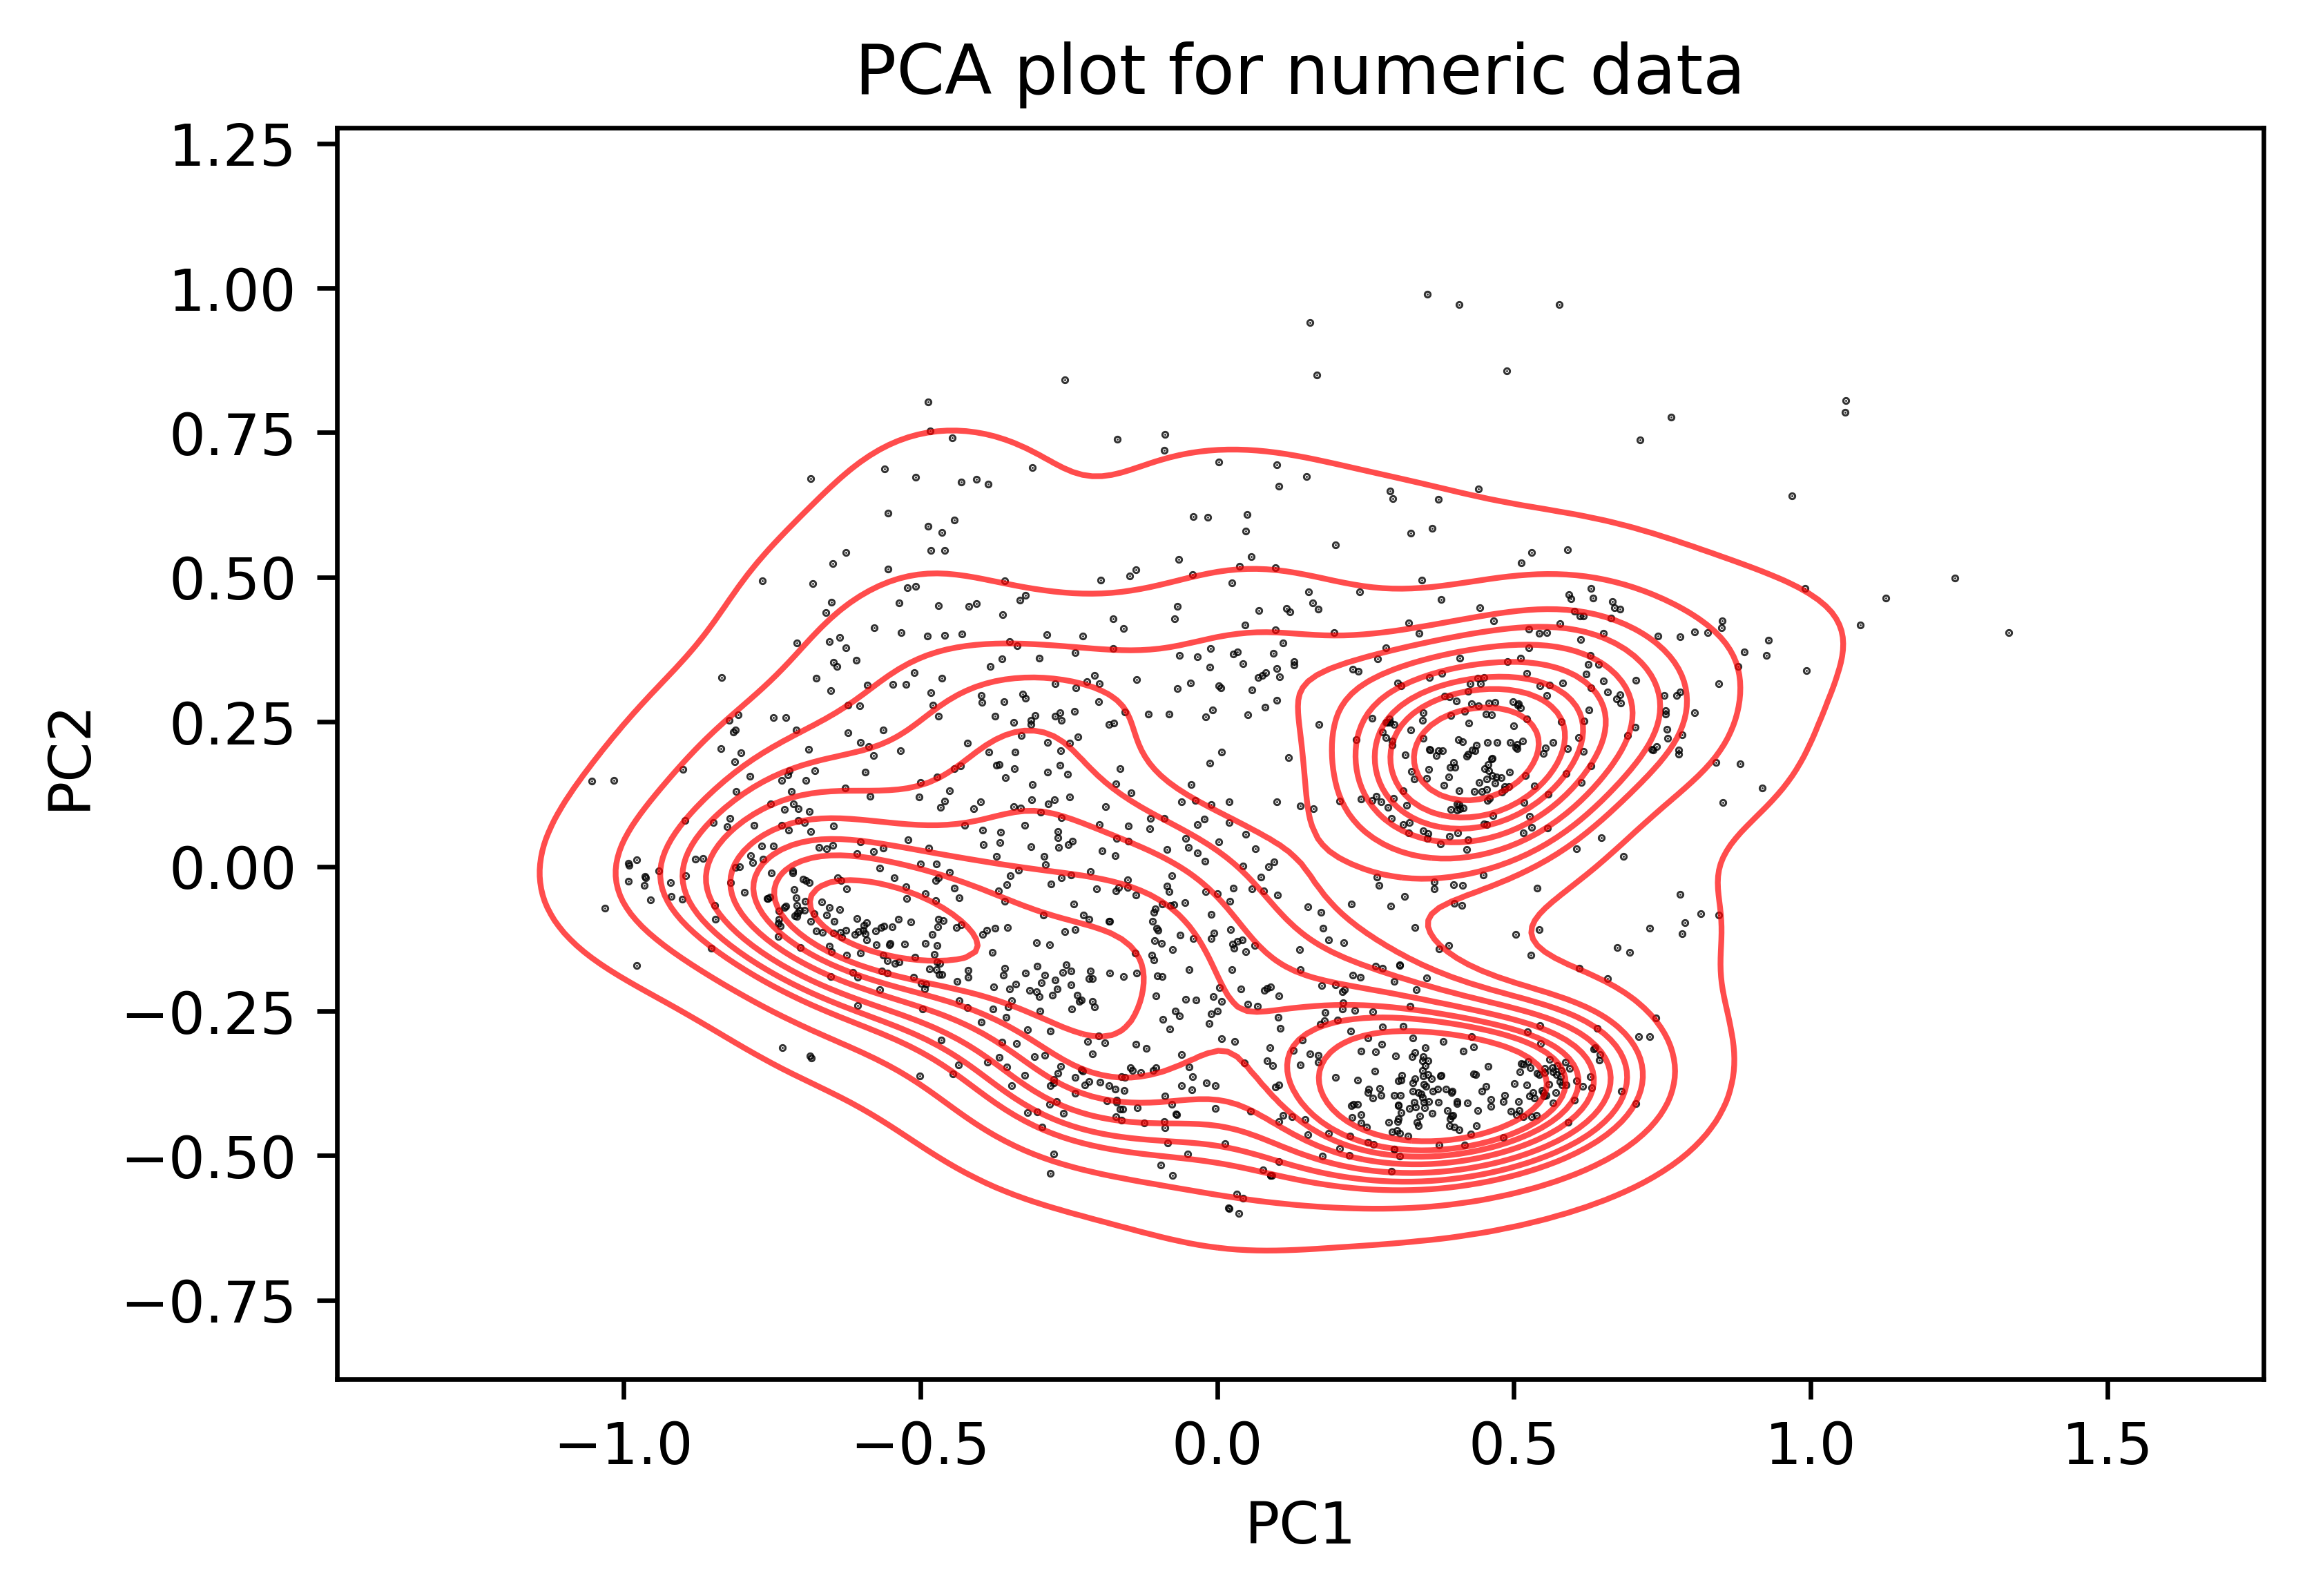

In [32]:
plt.figure()#figsize = (4,3))
sns.kdeplot(x = some_x[:,0],y = some_x[:,1],color = 'Red',levels = 10,linewidths = 1,alpha = 0.7)
plt.scatter(some_x[:,0],some_x[:,1],s = 0.5,marker = '.',c = 'black',alpha = 0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot for numeric data')
print()

There are three epicentres of the PCA plot, implying some separability from just the numeric columns dataset.

#### Plotting function

In [33]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error

def rmse(_true,_pred):
    return mean_squared_error(_true,_pred,squared = 'False')

def quartet_plot(model,title = "",ret_series = True):
    """True vs Predicted plots, along with performance metric overlays.
    
    -- inputs --
    model : the model to be used in prediction
    title : title of the plot, also transformed for labelling the pd.Series
    ret_series : return a pd.Series to be appended into results df"""
    
    fig,ax = plt.subplots(nrows = 2,ncols = 2,figsize = (5,5),dpi = 400)
    
    true,pred = y_train,model.predict(x_train)
    if len(pred.shape) == 1:
        pred = pred[:,None]
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[0,0].scatter(true,pred,s = 2)
    ax[0,0].plot([_min,_max],[_min,_max],'k--')
    ax[0,0].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    true,pred = y_scaler.inverse_transform(true) / 1e6,y_scaler.inverse_transform(pred) / 1e6
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[1,0].scatter(true,pred,s = 2)
    ax[1,0].plot([_min,_max],[_min,_max],'k--')
    ax[1,0].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    train_rmse,train_r2 = rmse(true,pred),r2(true,pred)
    
    true,pred = y_test,model.predict(x_test)
    if len(pred.shape) == 1:
        pred = pred[:,None]
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[0,1].scatter(true,pred,c = 'red',s = 2)
    ax[0,1].plot([_min,_max],[_min,_max],'k--')
    ax[0,1].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    true,pred = y_scaler.inverse_transform(true) / 1e6,y_scaler.inverse_transform(pred) / 1e6
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[1,1].scatter(true,pred,c = 'red',s = 2)
    ax[1,1].plot([_min,_max],[_min,_max],'k--')
    ax[1,1].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    test_rmse,test_r2 = rmse(true,pred),r2(true,pred)
    
    ax[0,0].set(ylabel = 'Scaled')
    ax[1,0].set(xlabel = 'Train',ylabel = 'Raw House Price (Million $)')
    ax[1,1].set(xlabel = 'Test')
    
    fig.suptitle(title)
    fig.tight_layout()
    
    if ret_series:
        return pd.Series({'train_rmse' : train_rmse, 'train_r2' : train_r2, 'test_rmse' : test_rmse, 'test_r2' : test_r2},name = '_'.join(title.lower().split()))

In [34]:
x_train,x_test = x_train.to_numpy(),x_test.to_numpy()

#### Results df

In [35]:
results = pd.DataFrame(columns = ('train_rmse','train_r2','test_rmse','test_r2'))

### Linear Regression

This house price dataset, as expected, has a few outliers in the data. These are generally the very expensive properties that are only really expensive because of very difficult to predict attributes. Factors affecting house prices of mansions are very likely to be different compared with factors that affect generic housing.

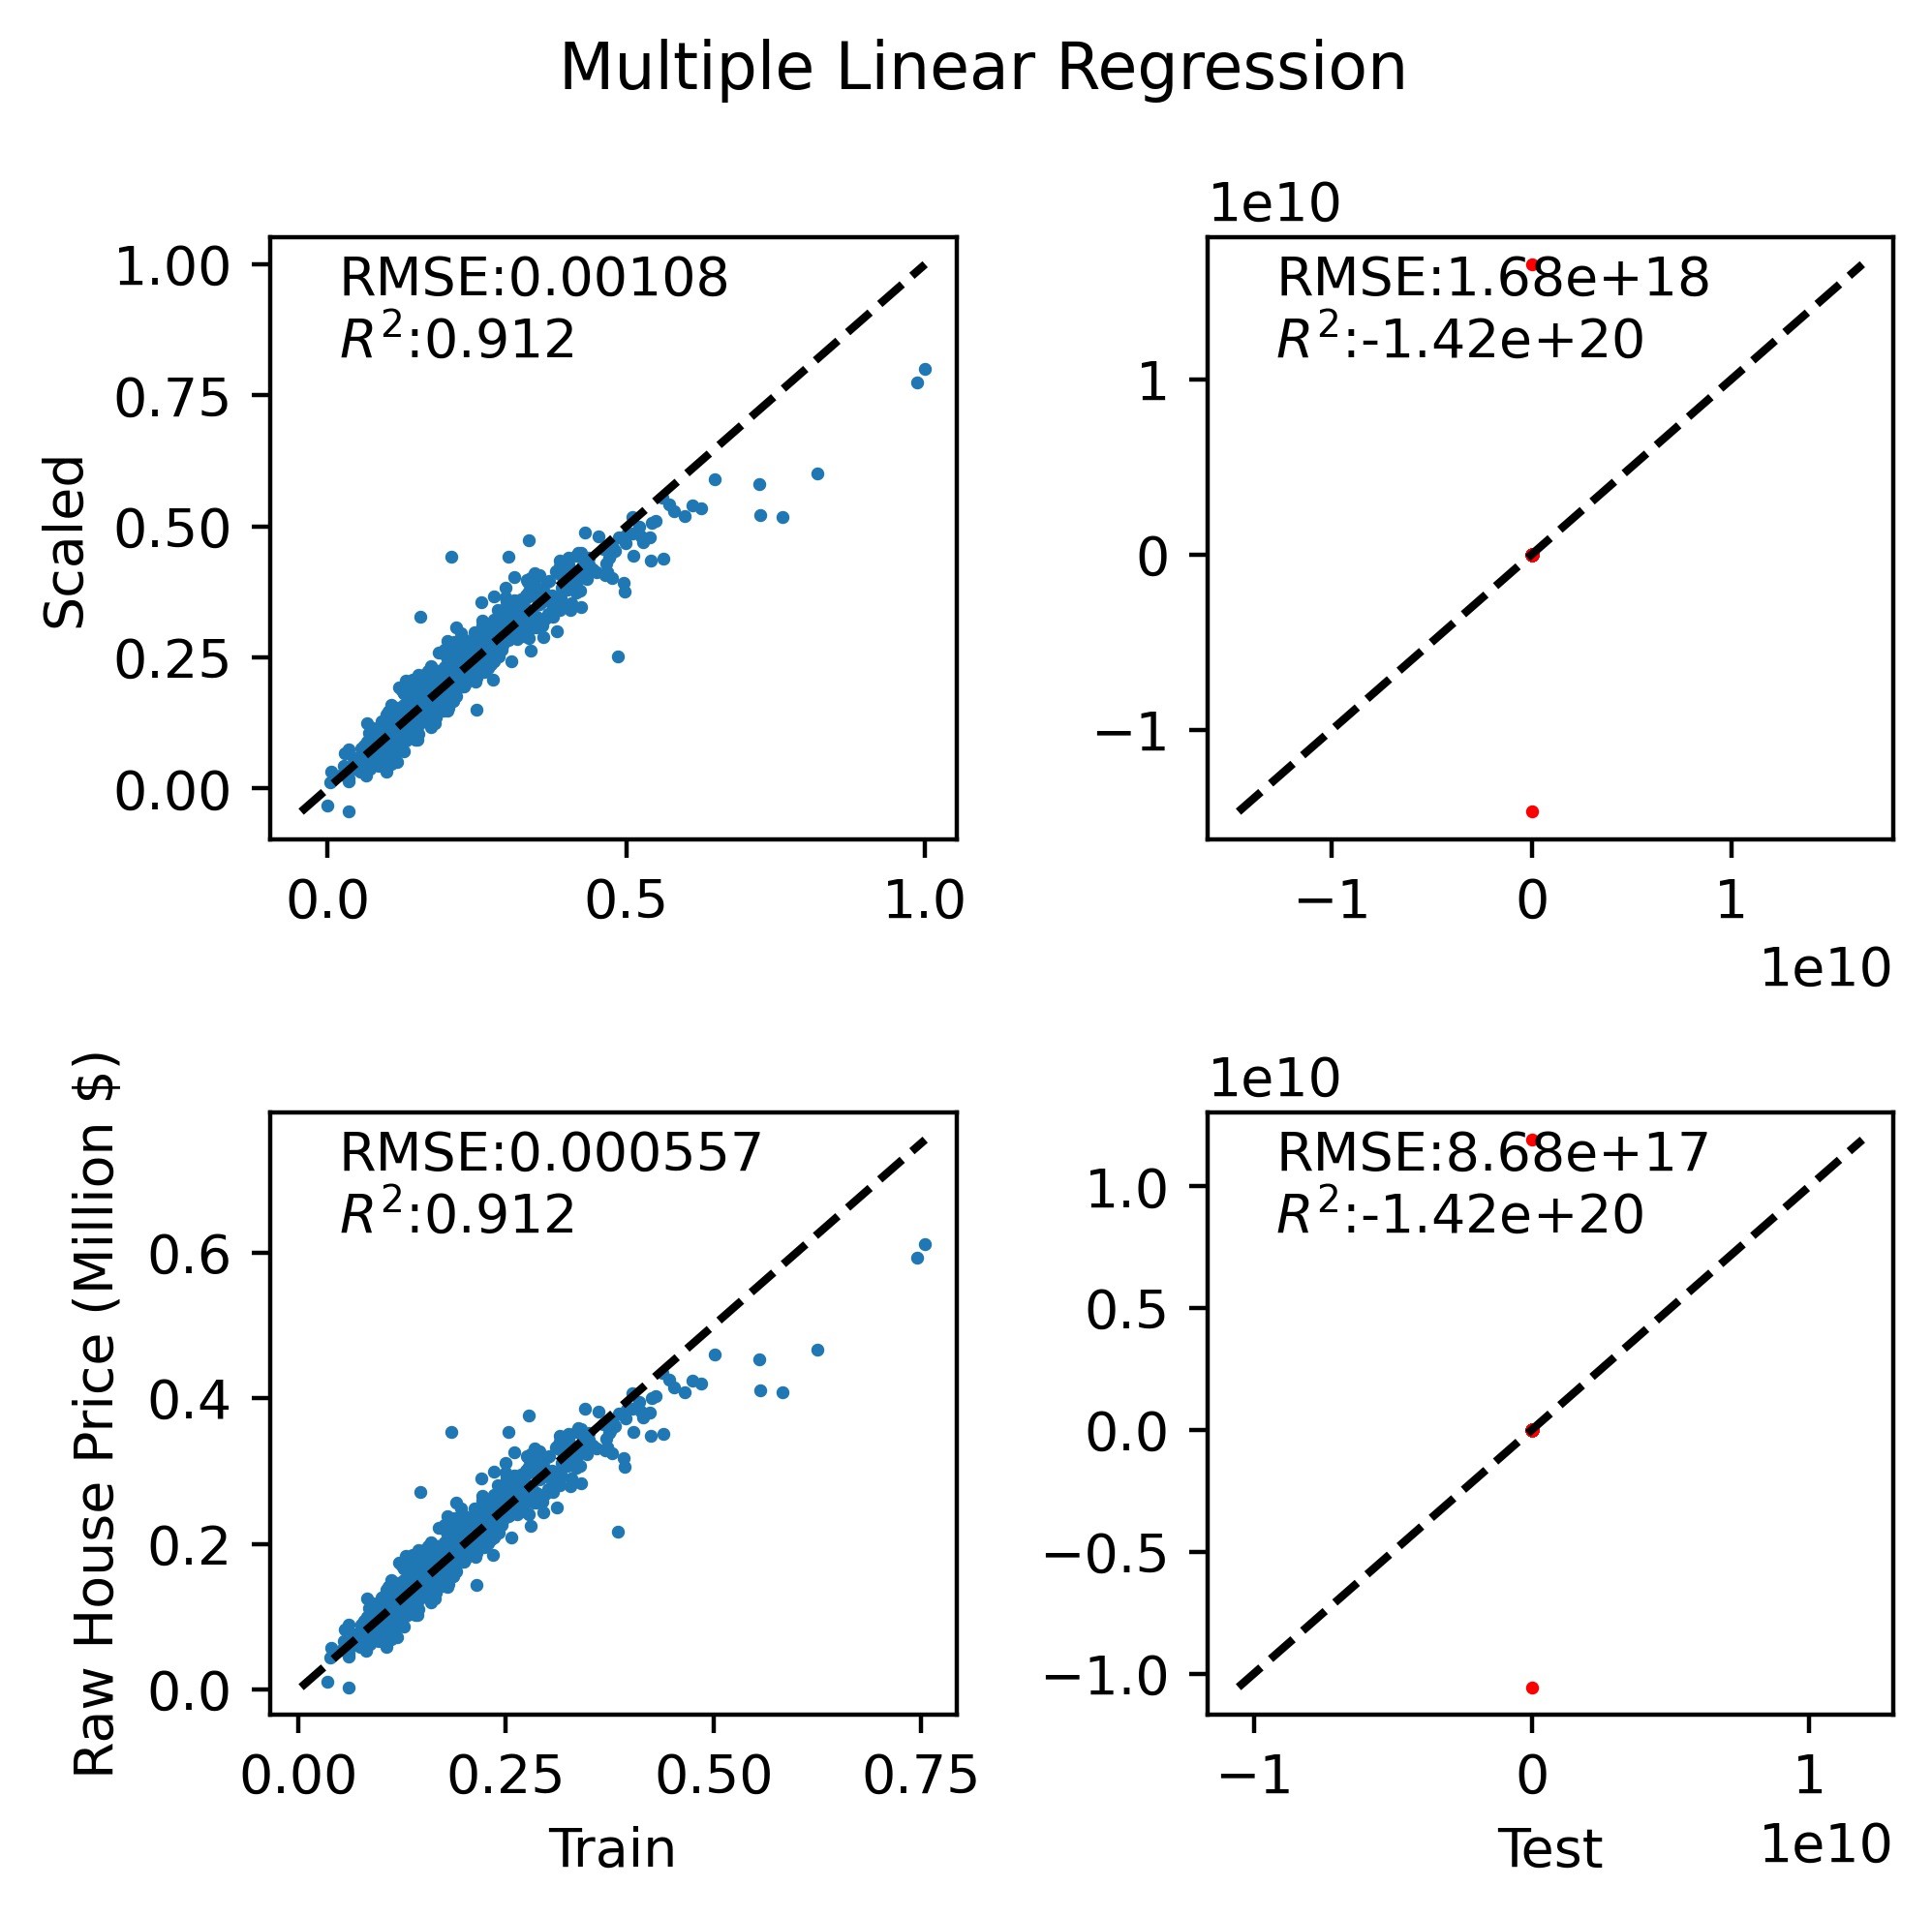

In [36]:
from sklearn.linear_model import LinearRegression
Linear_model = LinearRegression().fit(x_train,y_train)
row = quartet_plot(Linear_model,title = 'Multiple Linear Regression')
results = results.append(row)

Here is a **classic** example of overfitting - where the model fits the training data much too well with low bias but lacks any generalizability to unseen data (high variance). The dataset trained upon has many columns in relation to the number of data points to train from, and so as a result the coefficients of the model are extreme (see plot at end of section).

### Regularizing Linear Methods

Lasso and ridge regression are variants of multiple linear regression which use regularization, a technique that penalizes large coefficient terms in the model parameters that reduces overfitting. Ridge uses the L2 norm $[\hat \beta] ^2$ of the coefficients, while Lasso uses the L1 norm $|\hat \beta|$. The sklearn functions use leave-one-out cross validation to choose the regularization parameter $\lambda$ that scales the coefficient norms optimally from a range of candidate values (left as default here).

#### Lasso

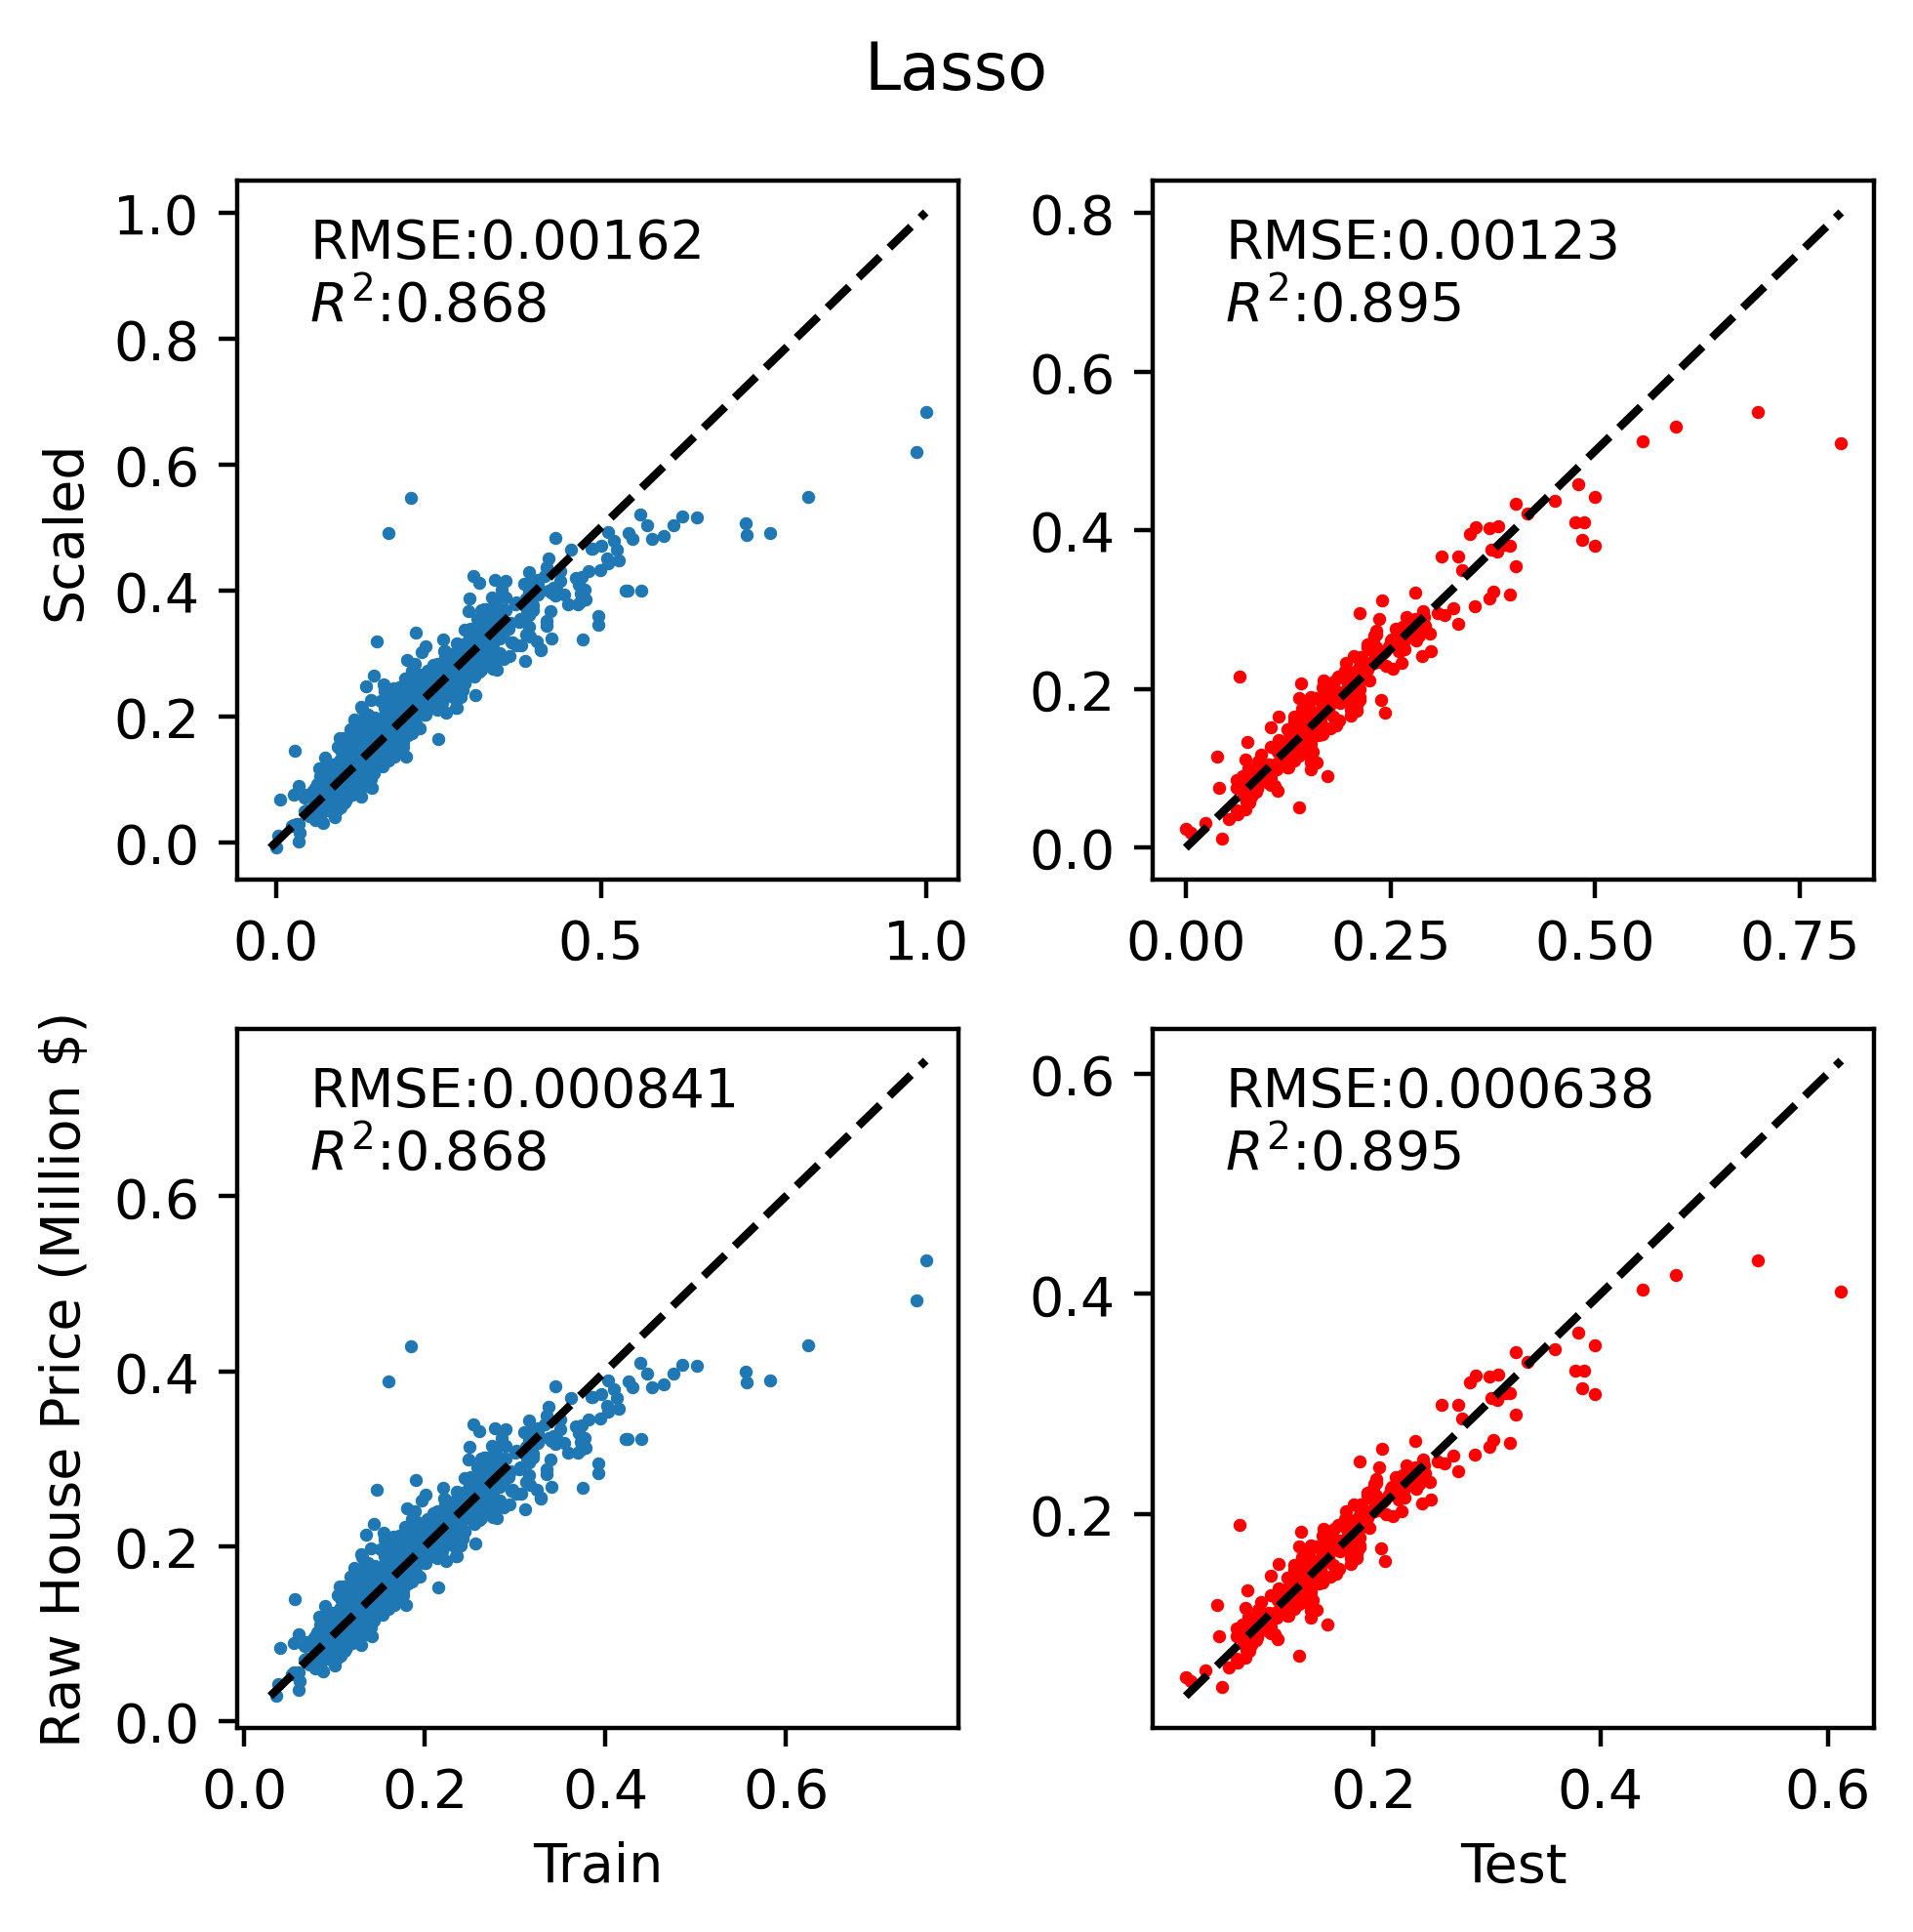

In [37]:
from sklearn.linear_model import LassoCV
Lasso_model = LassoCV(normalize = False).fit(x_train,y_train.ravel())
row = quartet_plot(Lasso_model,title = "Lasso")
results = results.append(row)

#### Ridge

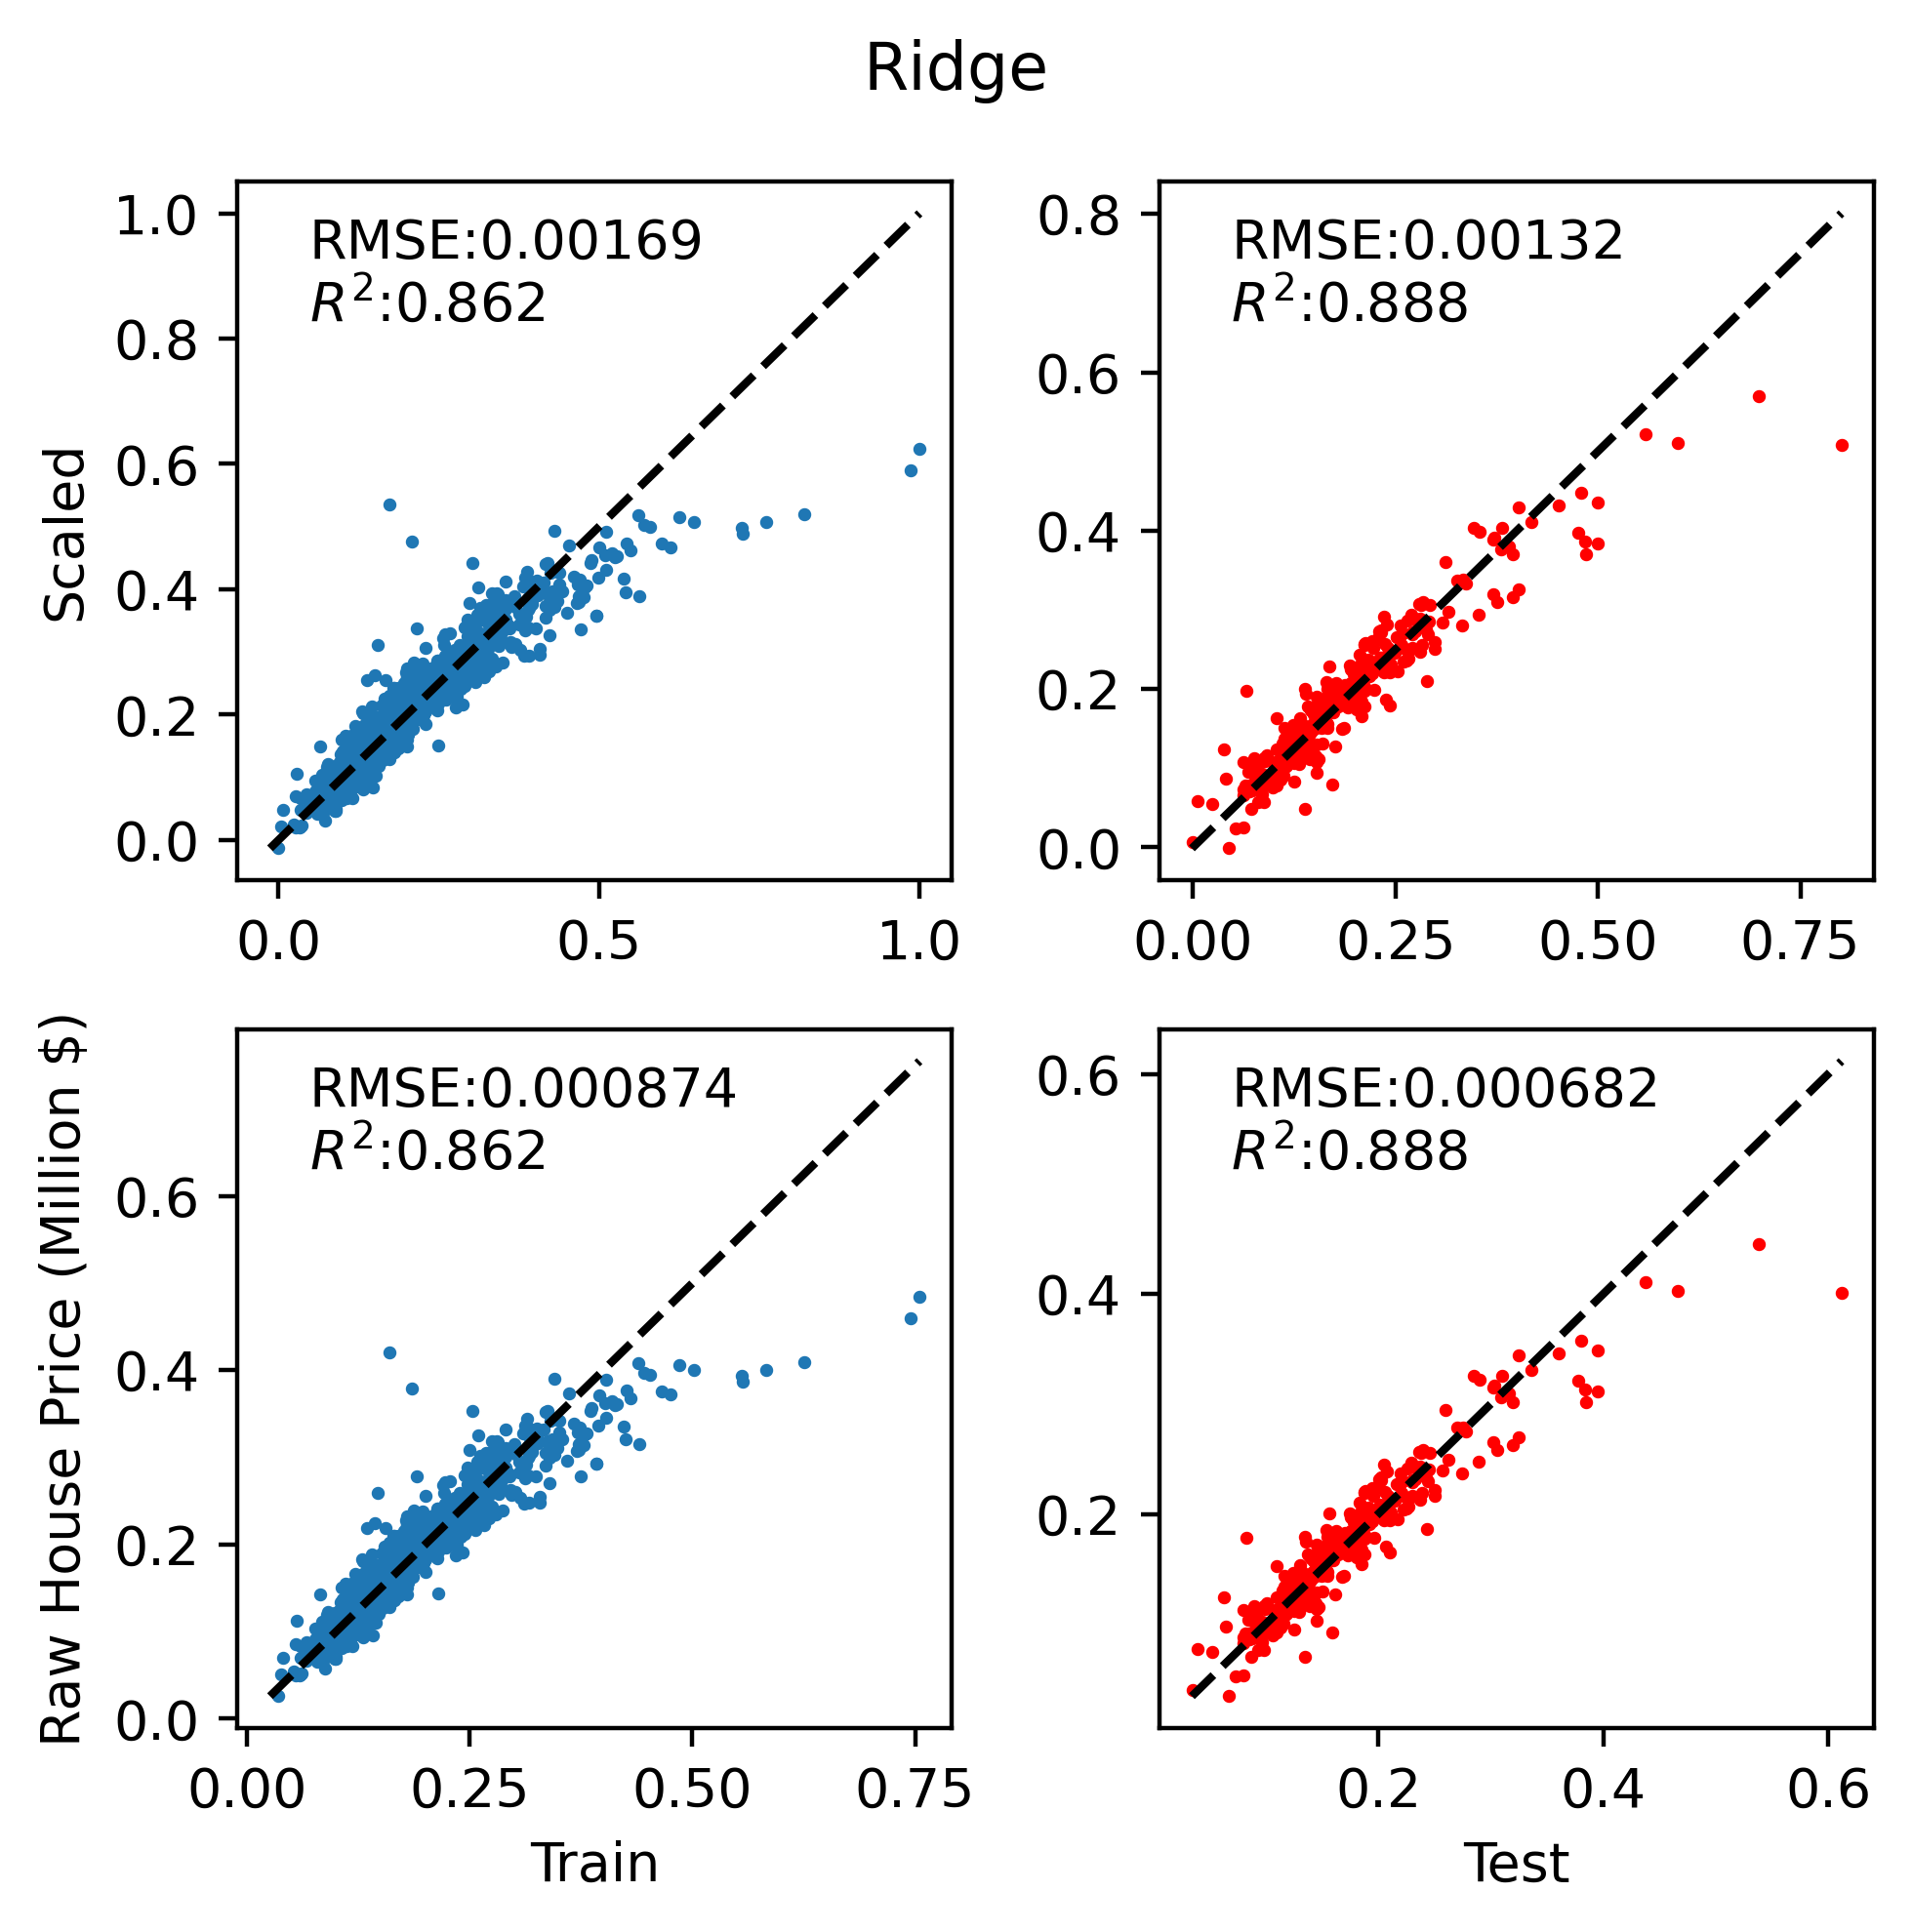

In [38]:
from sklearn.linear_model import RidgeCV
Ridge_model = RidgeCV(normalize = False).fit(x_train,y_train.ravel())
row = quartet_plot(Ridge_model,title = "Ridge")
results = results.append(row)

These regularized methods are much better, at the expense of a marginally small increase in training RMSE, the model has managd to predict unseen cases very well, comprising high $R^2$ values.

In [39]:
print(Lasso_model.coef_[:5])
print(Ridge_model.coef_[:5])

[0.00555642 0.         0.         0.         0.        ]
[ 0.00650049 -0.00204575  0.00440798  0.00165351  0.00139703]


With lasso regression, model parameters can be zero, however with ridge regression they can only get asymptotically close to zero. With especially large numbers of columns, like this dataset, eliminating redundant columns is a great benefit of lasso regularization methods.

#### Elastic Net

Elastic Net regression combines L1 and L2 regularization, where the ratio between the two forms is a hyperparameter to be optimized. With an l1_ratio of 1, the ElasticNet becomes uses only L1 regularization and so is lasso, and with a ratio of 0 it becomes L2 and ridge. The ElasticNetCV uses cross validation (5-fold by default) to pick the optimal l1_ratio from a given range.

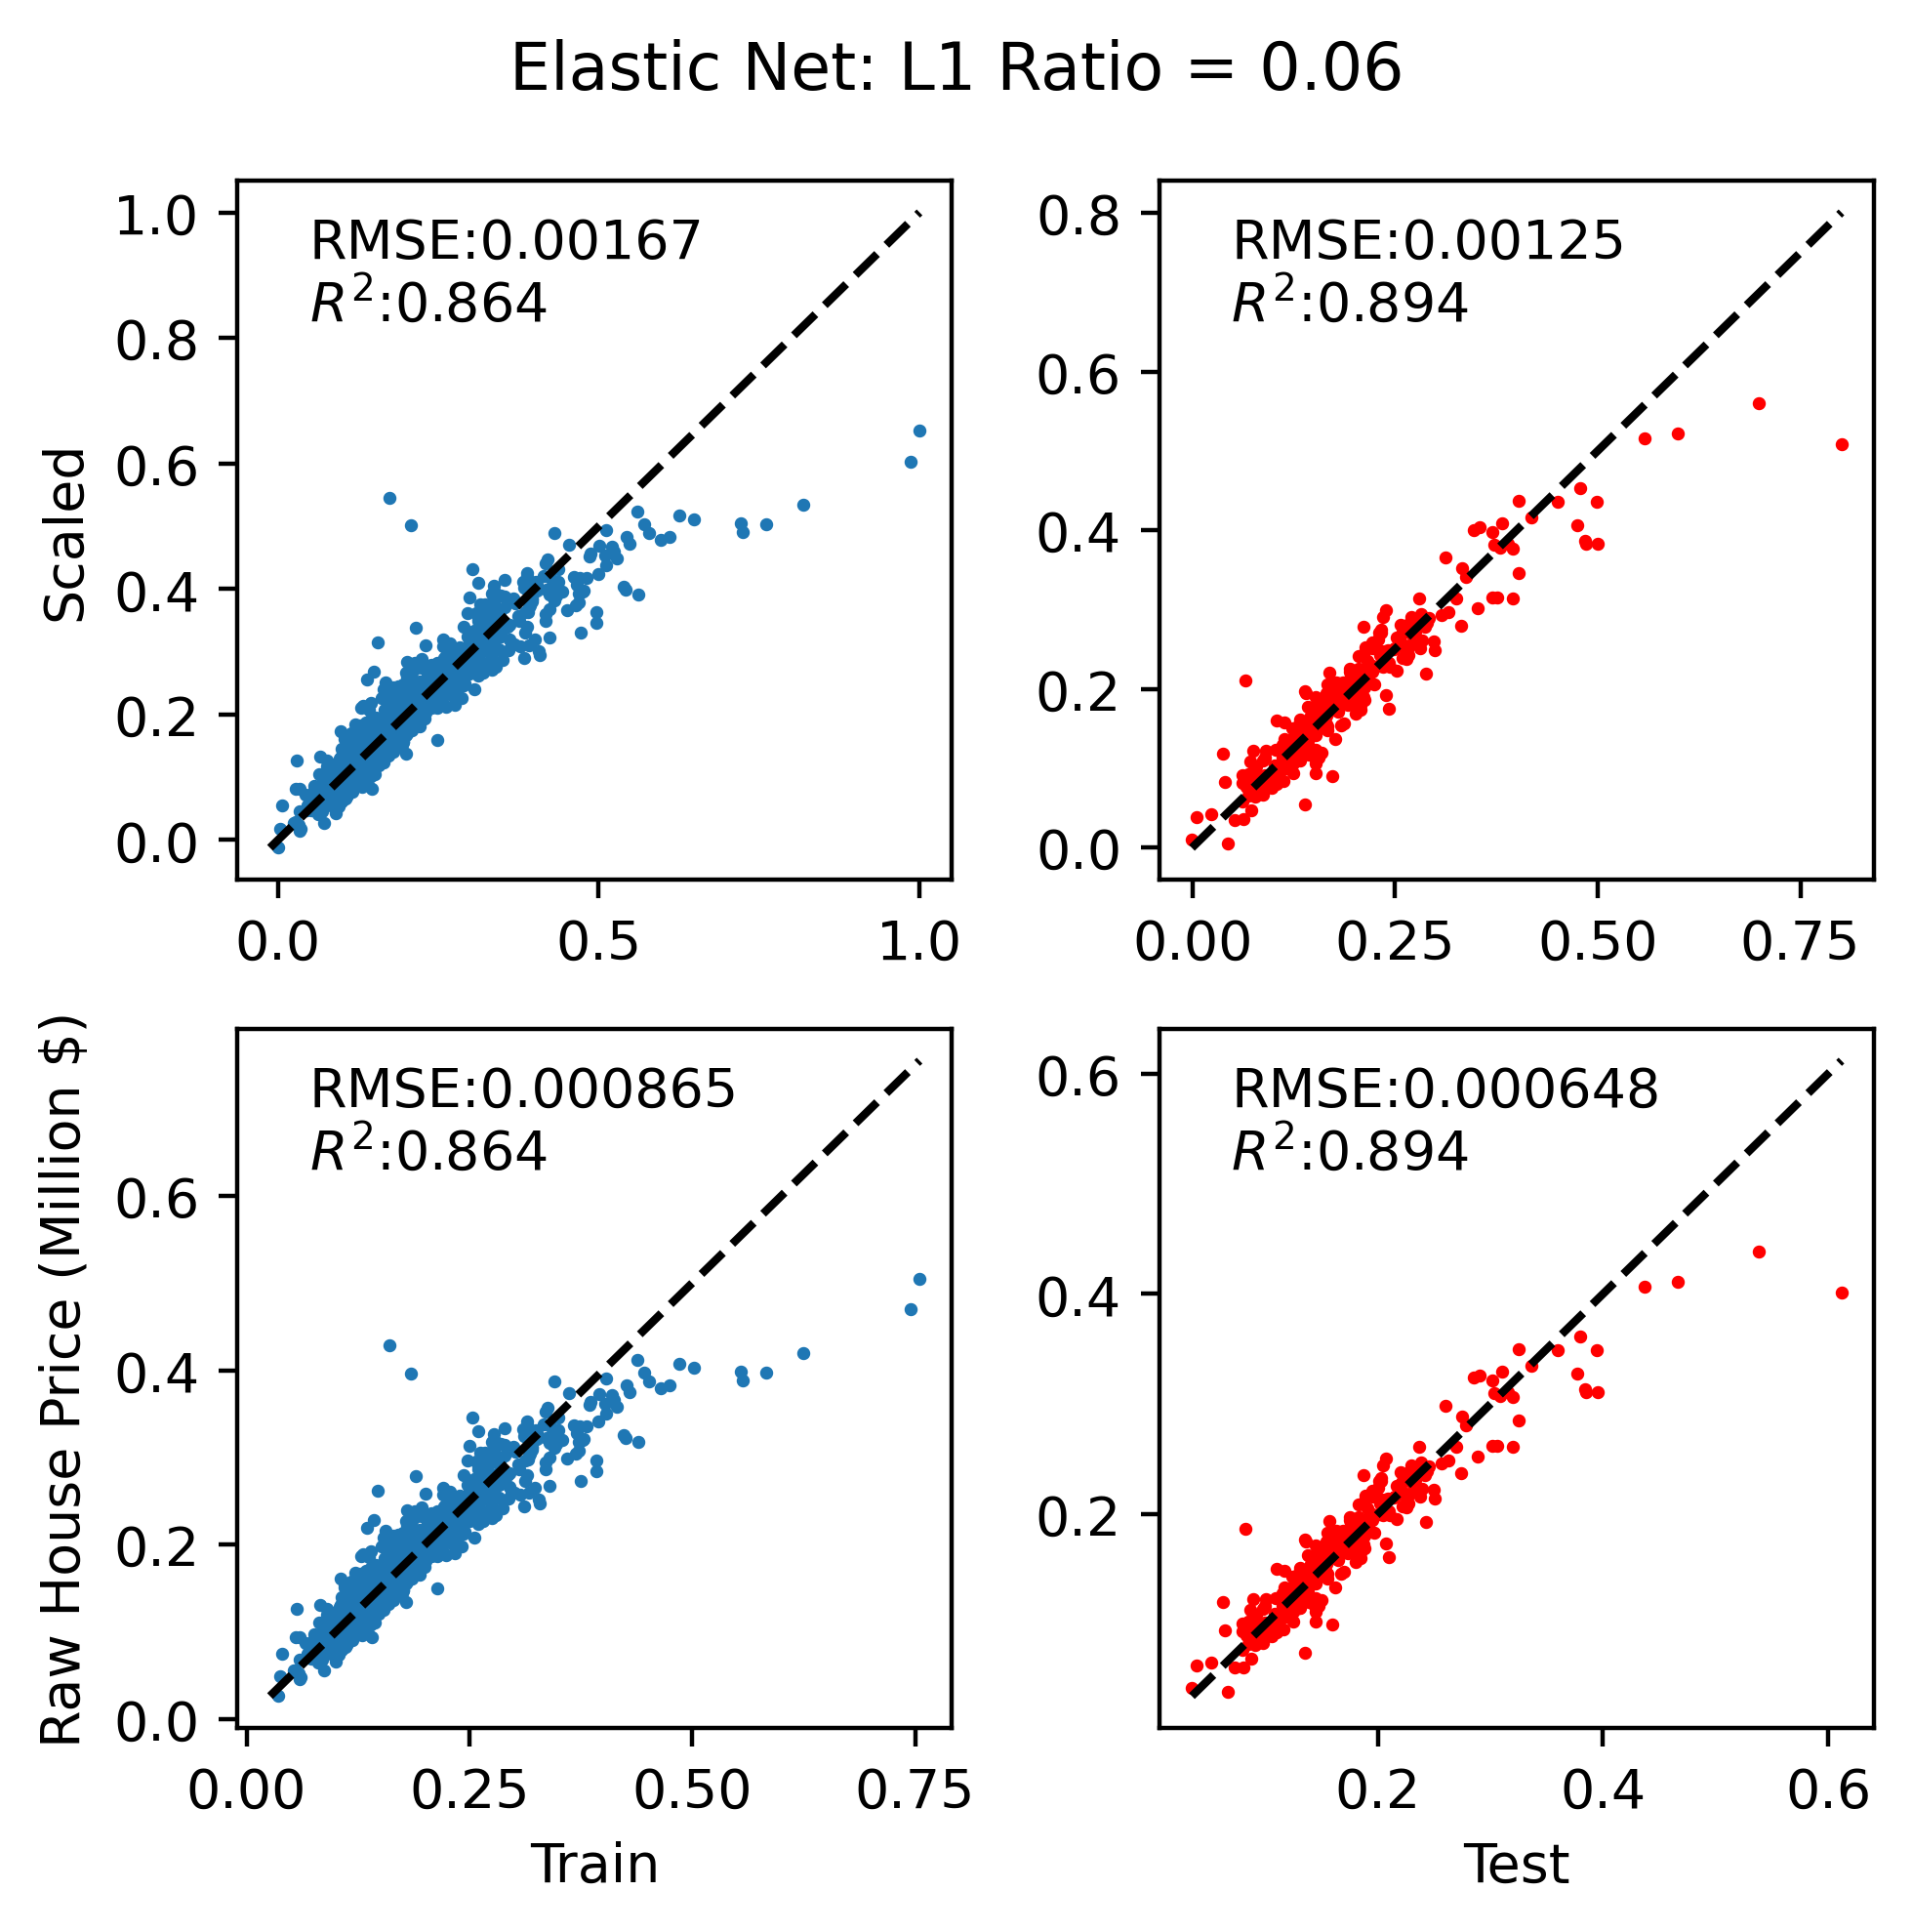

In [40]:
from sklearn.linear_model import ElasticNetCV
l1_ratio_list = np.arange(0.01,1,0.01)
ElNet_model = ElasticNetCV(normalize = False,l1_ratio = l1_ratio_list).fit(x_train,y_train.ravel())
row = quartet_plot(ElNet_model,title = "Elastic Net: L1 Ratio = " + str(np.around(ElNet_model.l1_ratio_,4)))
results = results.append(row)

### Huber Loss

With some significant outliers in the training data, the regression is being drawn to those points with more significant leverage and residuals, therefore skewing the model towards outliers. Using the huber loss function instead of the mse makes the deviance (which will be minimised) only increase linearly for larger residuals yet retain quadratic loss for smaller deviances.

\begin{align}
Huber(y,f(x)) = \left\{ \begin{array}{cl}
\frac{1}{2} \left(y-f(x)\right)^2 & |y-f(x)| \le \delta, \\
\delta \left(|y-f(x)|-\delta/2\right), & {otherwise.}
\end{array}\right.
\end{align}

For a given $\delta$, which is a hyperparameter to optimize. $f(x) = wX$ where $w$ is the weights and is also optimised, the sklearn function completes this optimization iteratively.

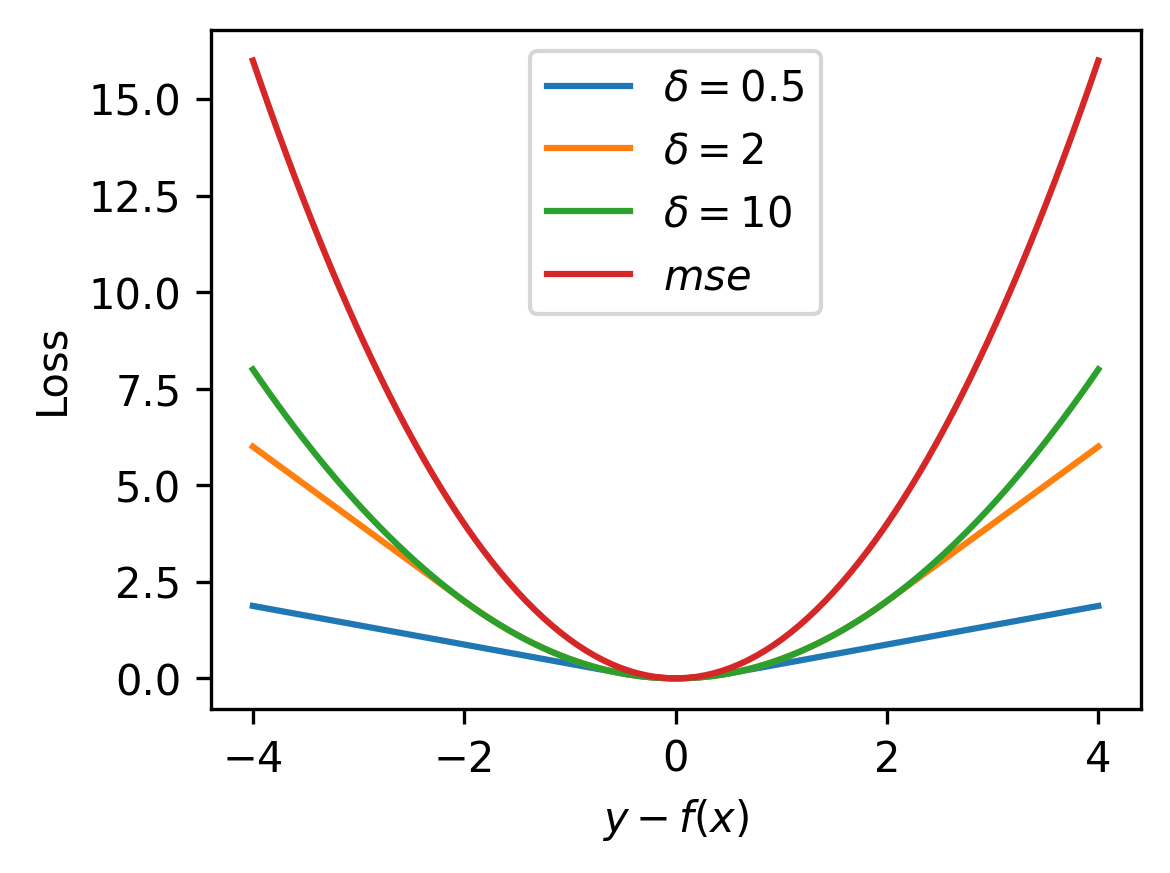

In [41]:
from scipy.special import huber
huber([10,4],[8,3])
real = np.linspace(-4,4,100)
predicted = np.zeros(len(real))
y1,y2,y3 = huber(0.5,real-predicted),huber(2,real-predicted),huber(10,real-predicted)

plt.figure(dpi = 300,figsize = (4,3))
plt.plot(real-predicted,y1,label = "$\delta = 0.5$")
plt.plot(real-predicted,y2,label = "$\delta = 2$")
plt.plot(real-predicted,y3,label = "$\delta = 10$")
plt.plot(real-predicted,(real-predicted)**2,label = "$mse$")
plt.legend()
plt.xlabel("$y - f(x)$")
plt.ylabel("Loss")
print()


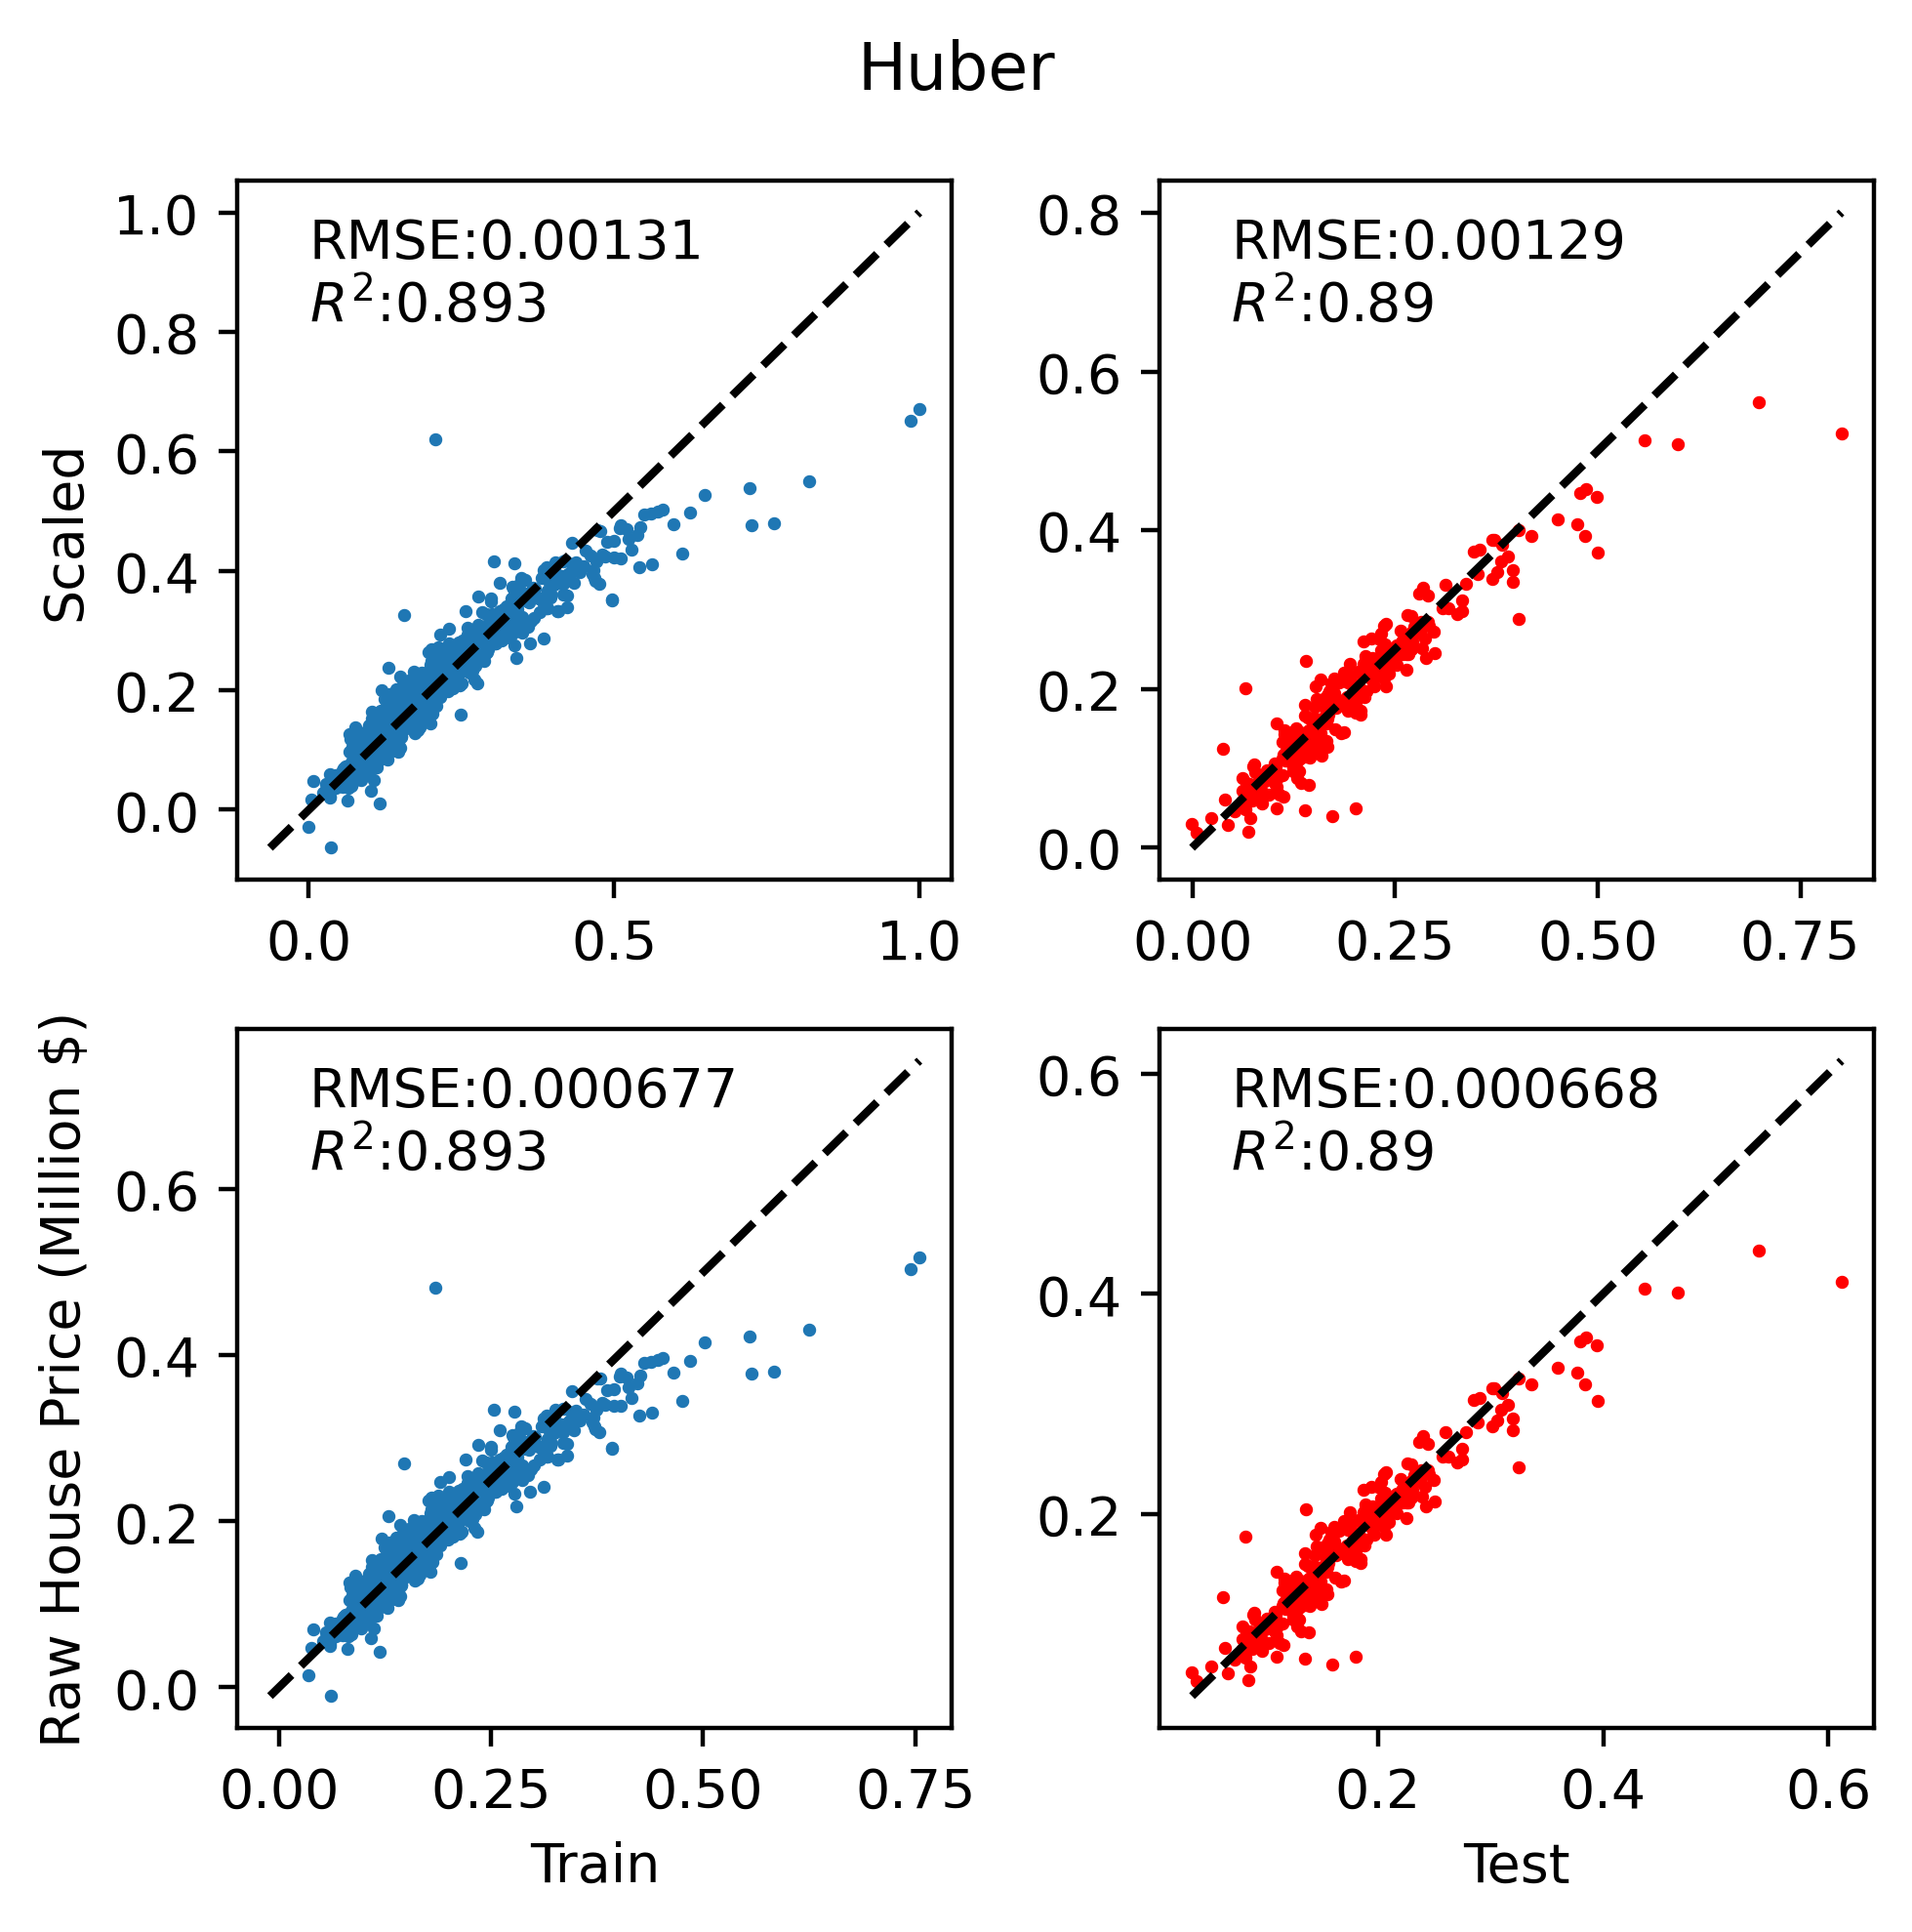

In [42]:
from sklearn.linear_model import HuberRegressor
Huber_model = HuberRegressor(max_iter = 2000).fit(x_train,y_train.ravel())
row = quartet_plot(Huber_model,title = "Huber")
results = results.append(row)

In [43]:
x_train[Huber_model.outliers_].shape

(423, 208)

### Fully Connected NN

A simple feed-forwards deep neural net is fitted to the data. This comprises of 5 hidden layers of decreasing size (can be seen in summary below), with relu activation functions. The optimizer is the well used Adam schotastic gradient descent function, with a fixed learning_rate of 0.00005. The loss to be optimized is the huber loss funciton with default values. As above, this should help by reducing the impact of outliers in the training data.

In [44]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
model = Sequential()
model.add(InputLayer(input_shape = (x_train.shape[1],)))
model.add(Dense(250,activation = 'relu'))
model.add(Dense(200,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(50,activation = 'relu'))
model.add(Dense(1,activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 5e-5),loss = 'huber')

2021-11-21 21:04:19.599653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-21 21:04:19.599671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-21 21:04:20.235107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-21 21:04:20.235125: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 21:04:20.235137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-11-21 21:04:20.235253: I tensorflow/core/platform/cpu_feature_gua

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               52250     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               50200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 127,651
Trainable params: 127,651
Non-trainable params: 0
_________________________________________________________________


Early Stopping is performed, helping to prevent overfitting to the training data. With a patience of 5, the model will keep on training up to 5 epochs after a minimum loss is found, allowing it to find a possibly more optimal set of weights and still stop before overfitting. For stopping, a pre-separated validation set (20%) is used to calculate validation losses, this is a set of data the model doesn't train on but tries to minimize loss for through early stopping.

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopper = EarlyStopping('val_loss',patience = 5, restore_best_weights = True)

In [47]:
## Batch size of 1 means the training is being done for each point independently
progress = model.fit(x_train,y_train,epochs = 100,batch_size = 1,verbose = 0,callbacks = earlyStopper,validation_split = 0.2)

2021-11-21 21:04:20.301193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 21:04:20.318538: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600395000 Hz


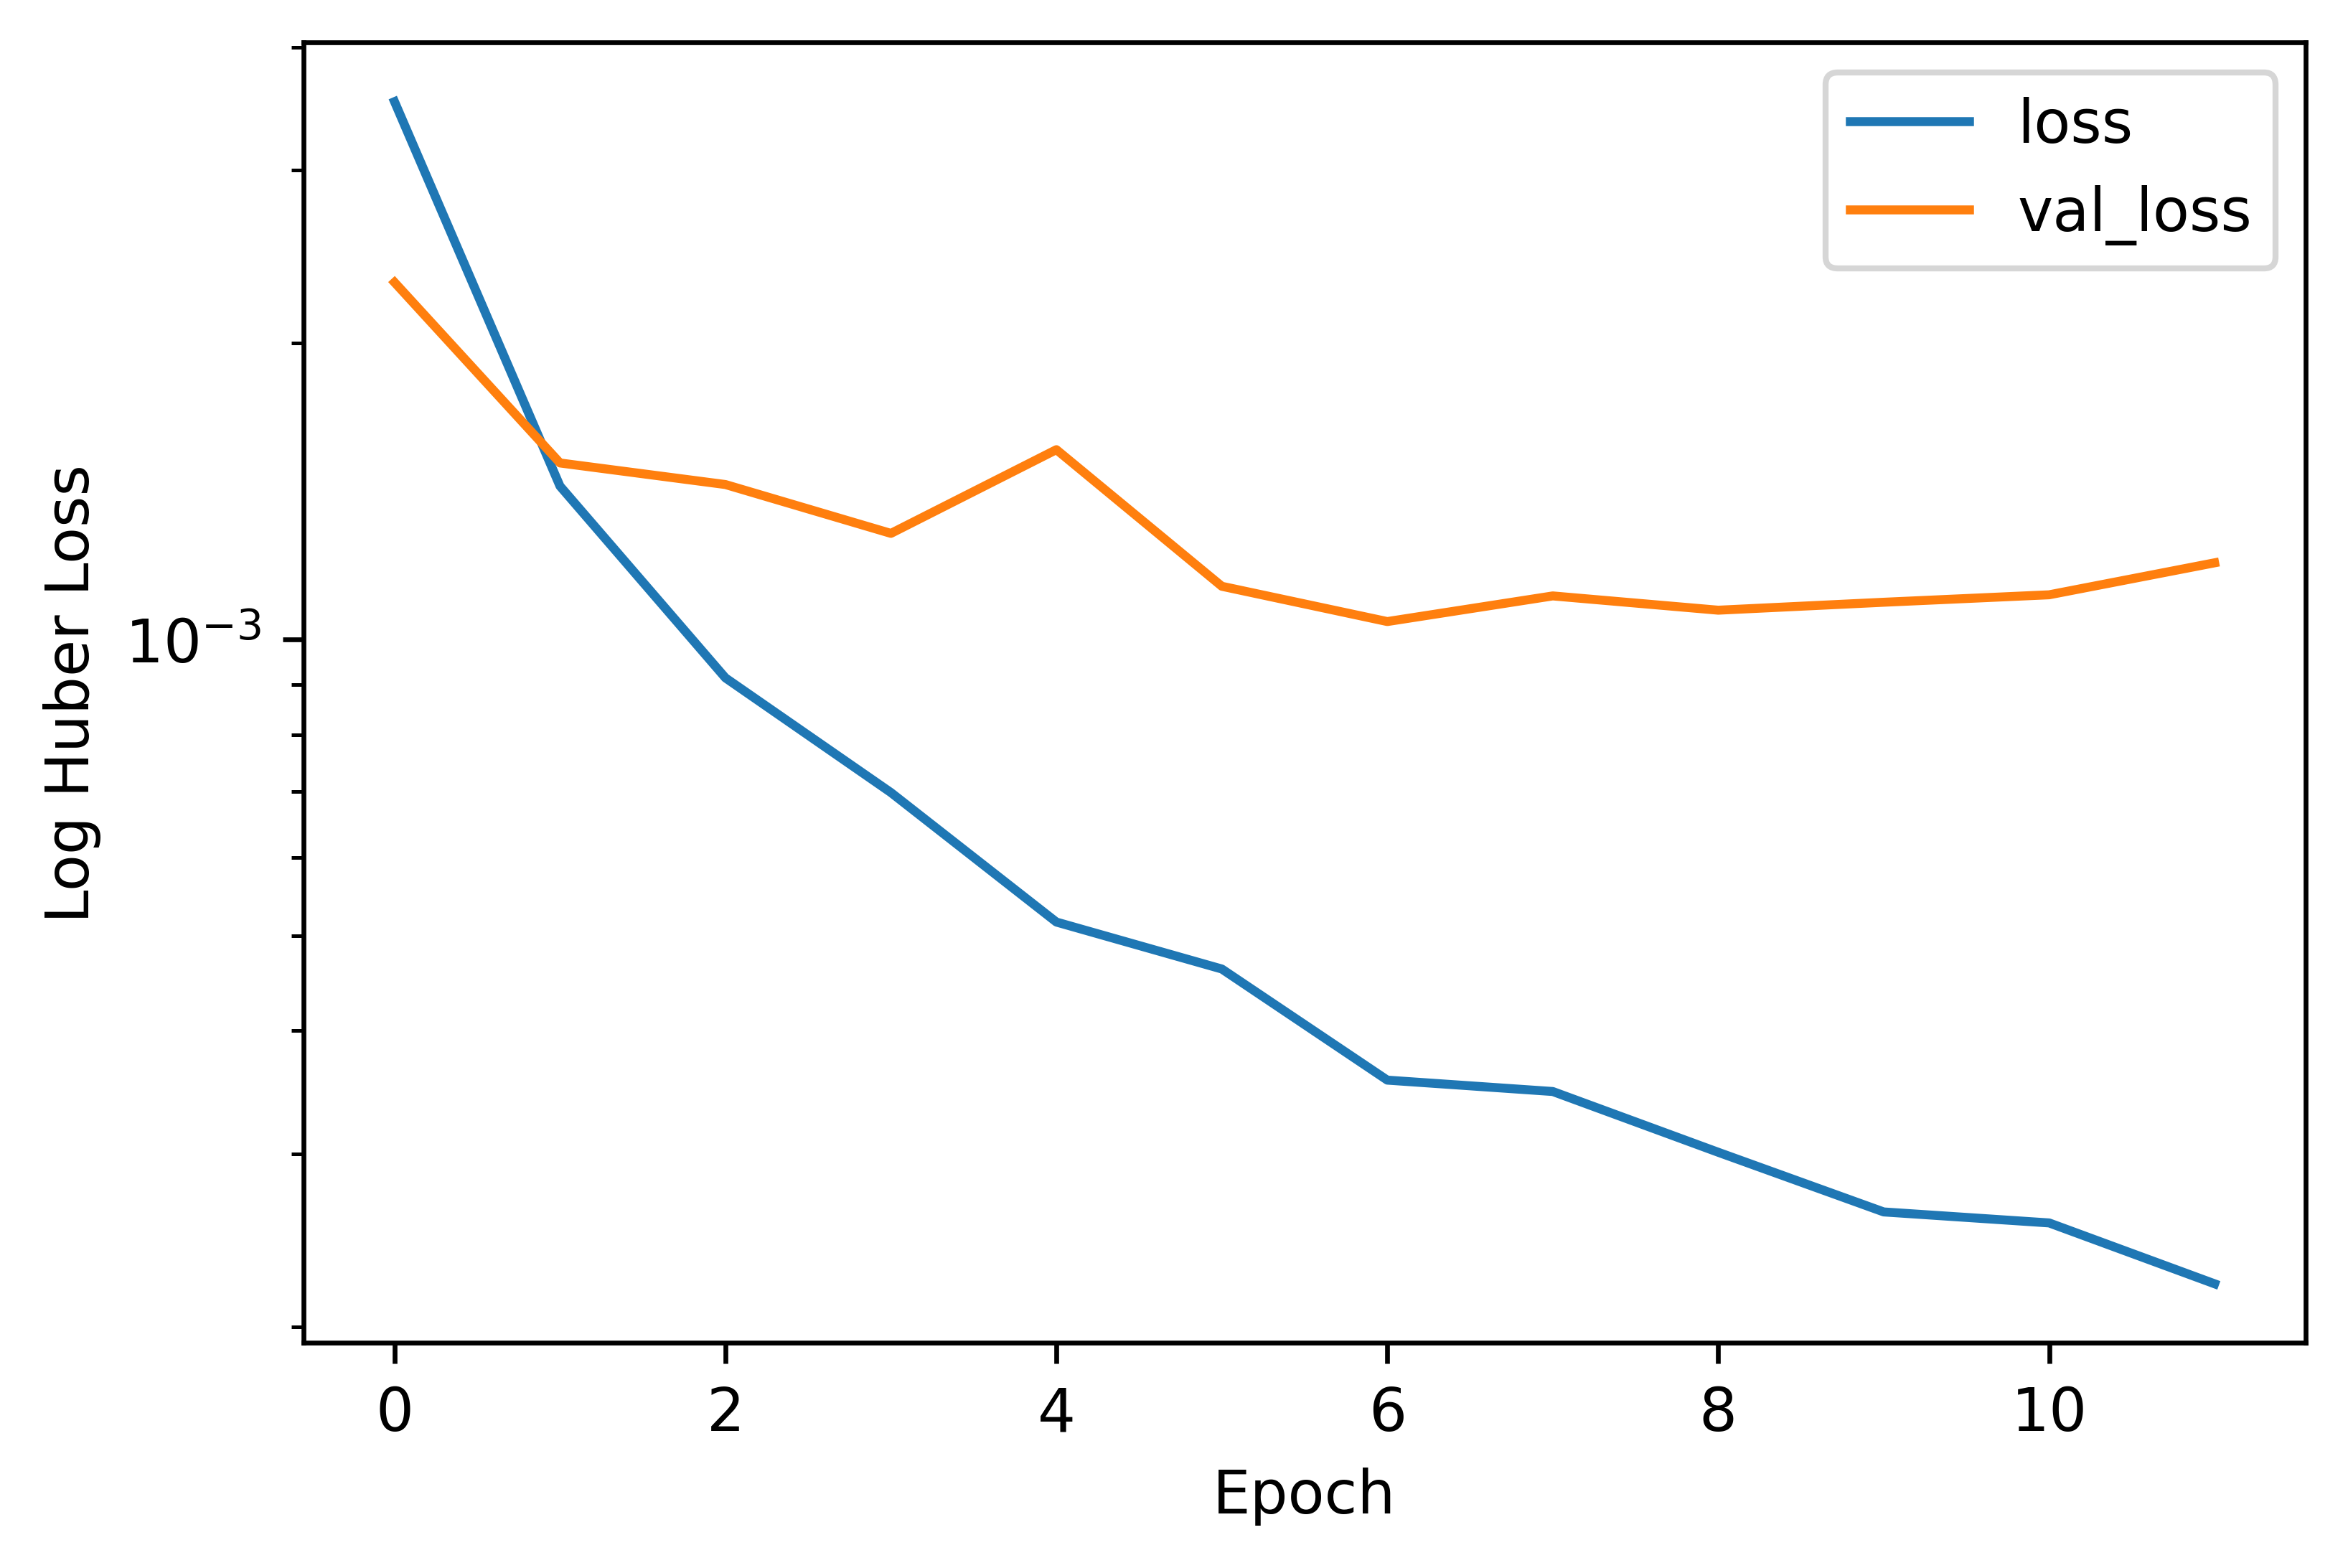

In [48]:
plt.plot(progress.history['loss'],label = 'loss')
plt.plot(progress.history['val_loss'],label = 'val_loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Log Huber Loss')
plt.legend()
print()

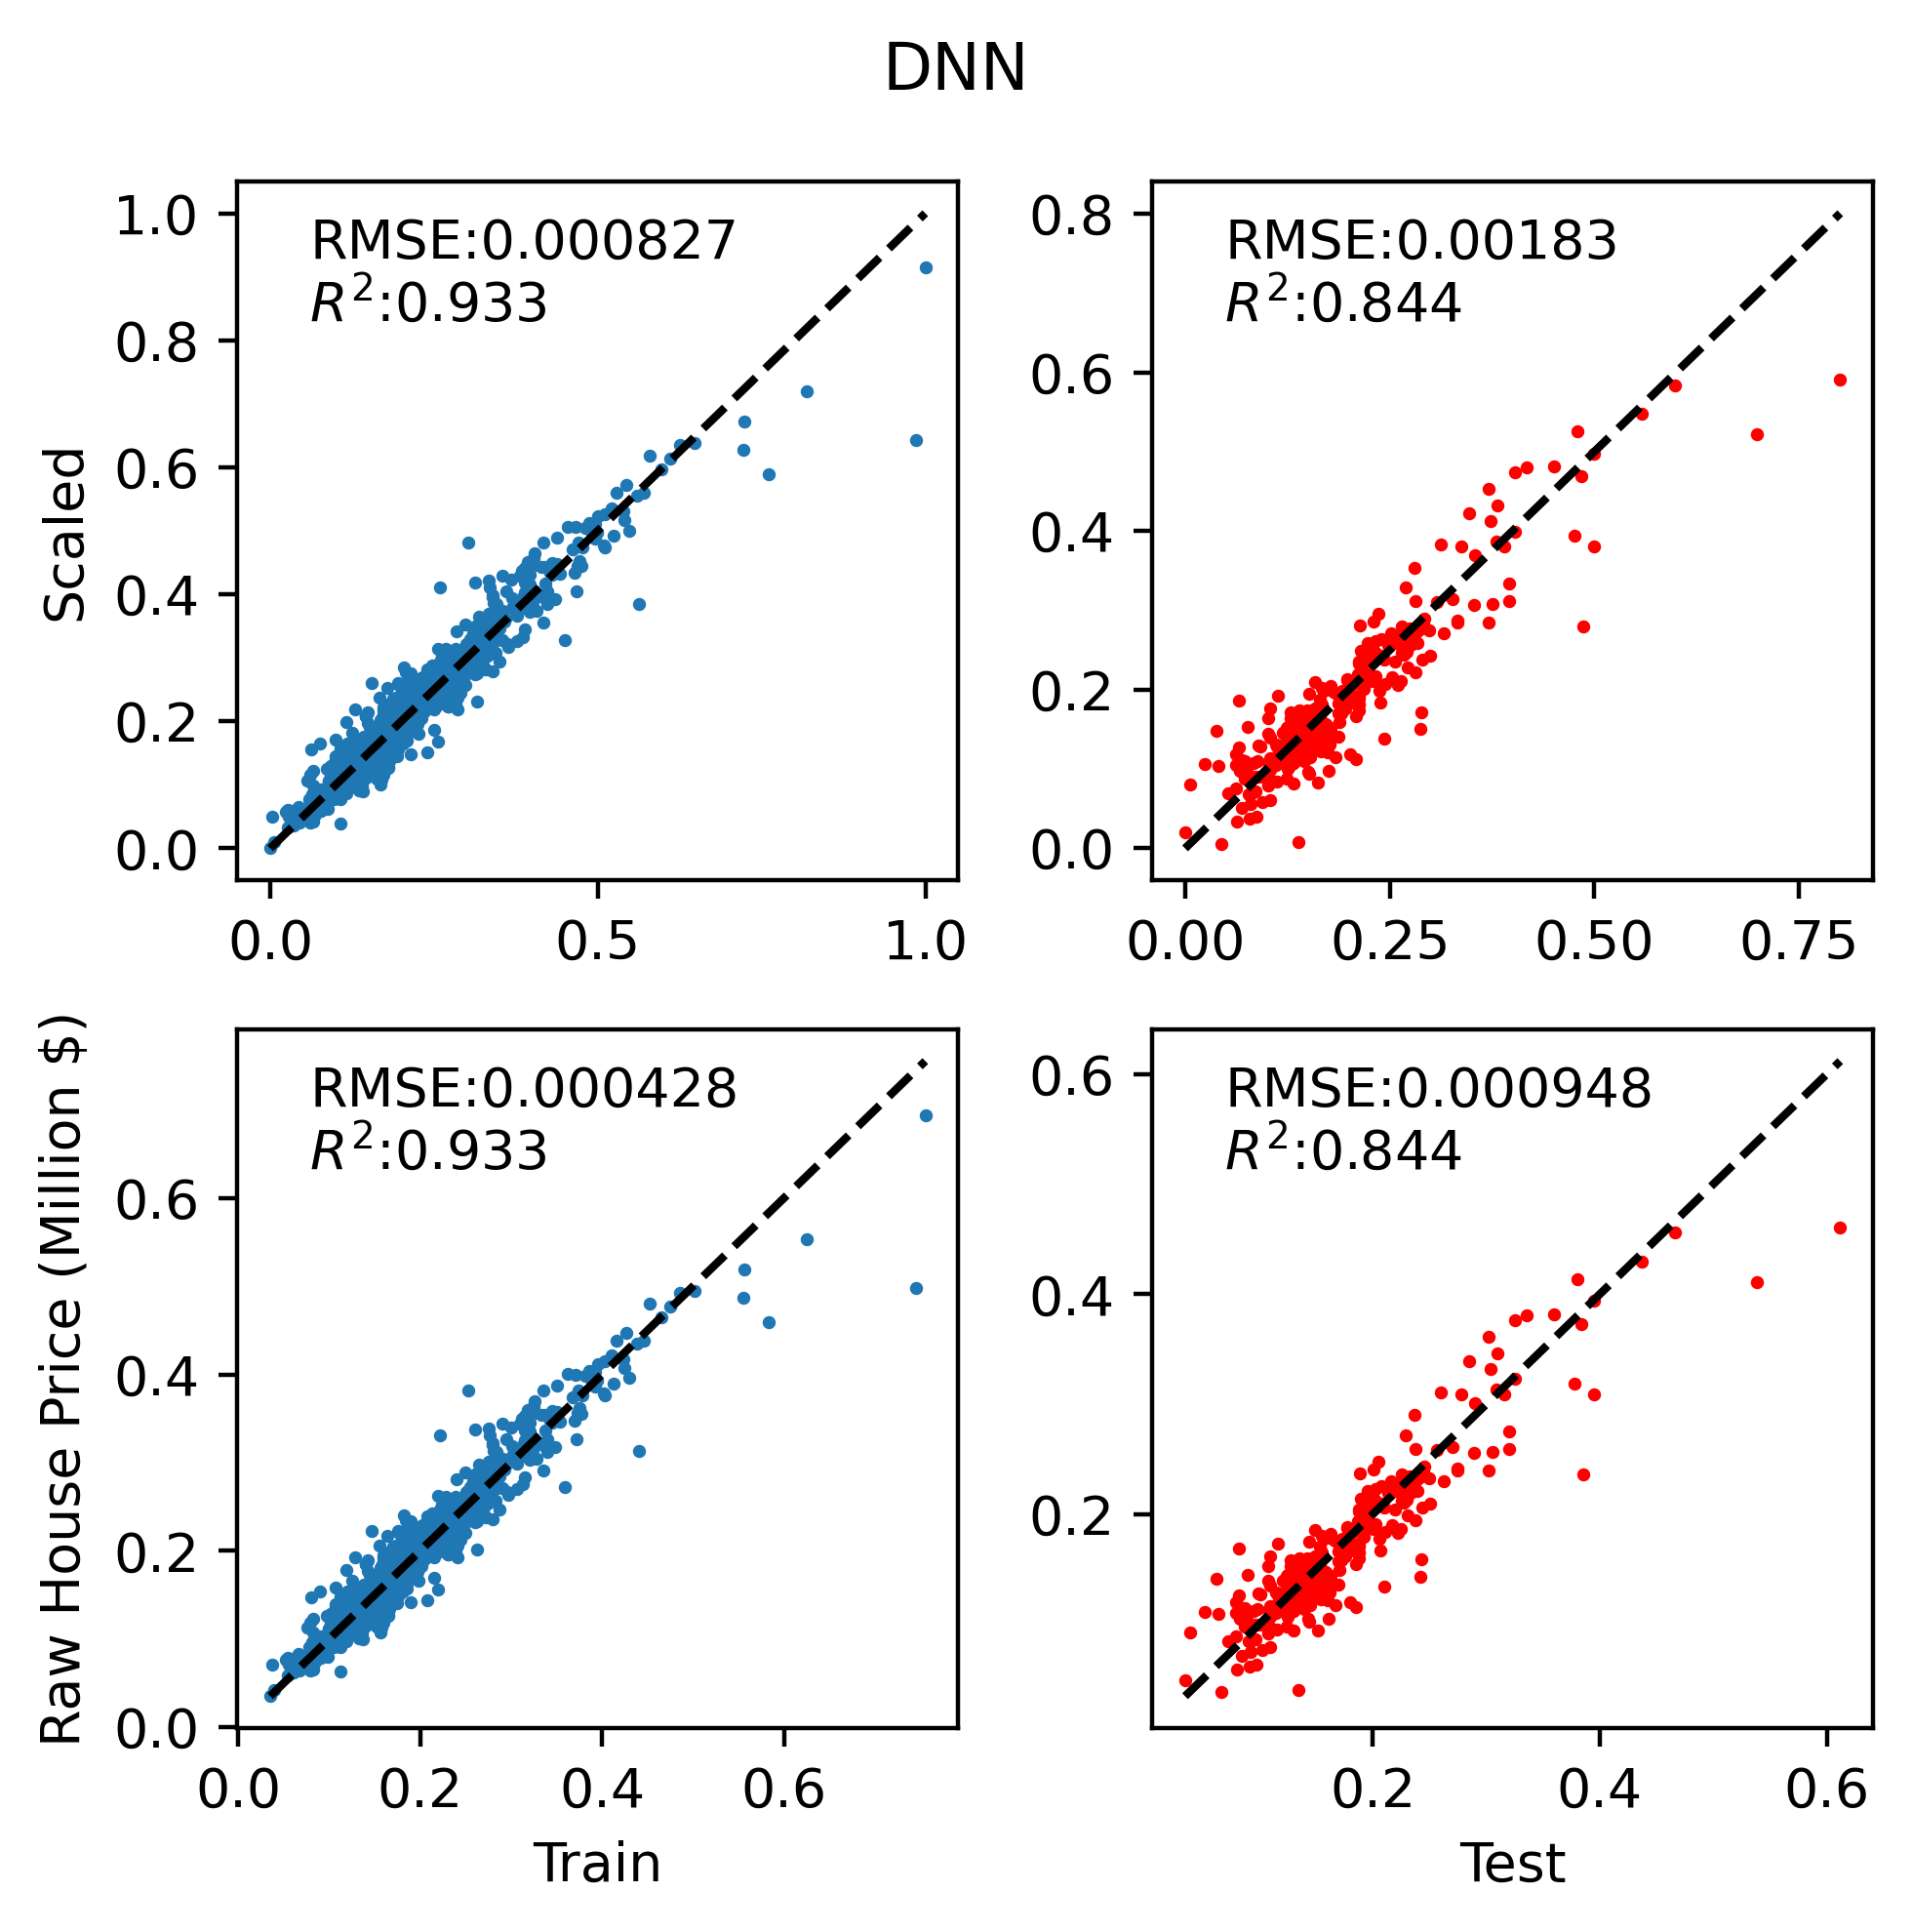

In [49]:
row = quartet_plot(model,title = "DNN")
results = results.append(row)

These plots show a slight amount of overfitting, despite the early stopping. Some other techniques to reduce this overfitting include kernel regularization, random dropout and batch normalization.  Despite this, the performance on the test set is similar to the good performing linear models above, and so is left as is.

In [50]:
print('rmse :',rmse(model.predict(x_test),y_test))

rmse : 0.0018299303466015103


# KNN

Not particularly good for this dataset as much of it is categorical and ordinal; using the KNN and euclidean distance assumes that each unit increase in an ordinal variable is equal, which is not necessarily the case. This is applied despite this drawback, and unsuprisingly has poor performance.

6


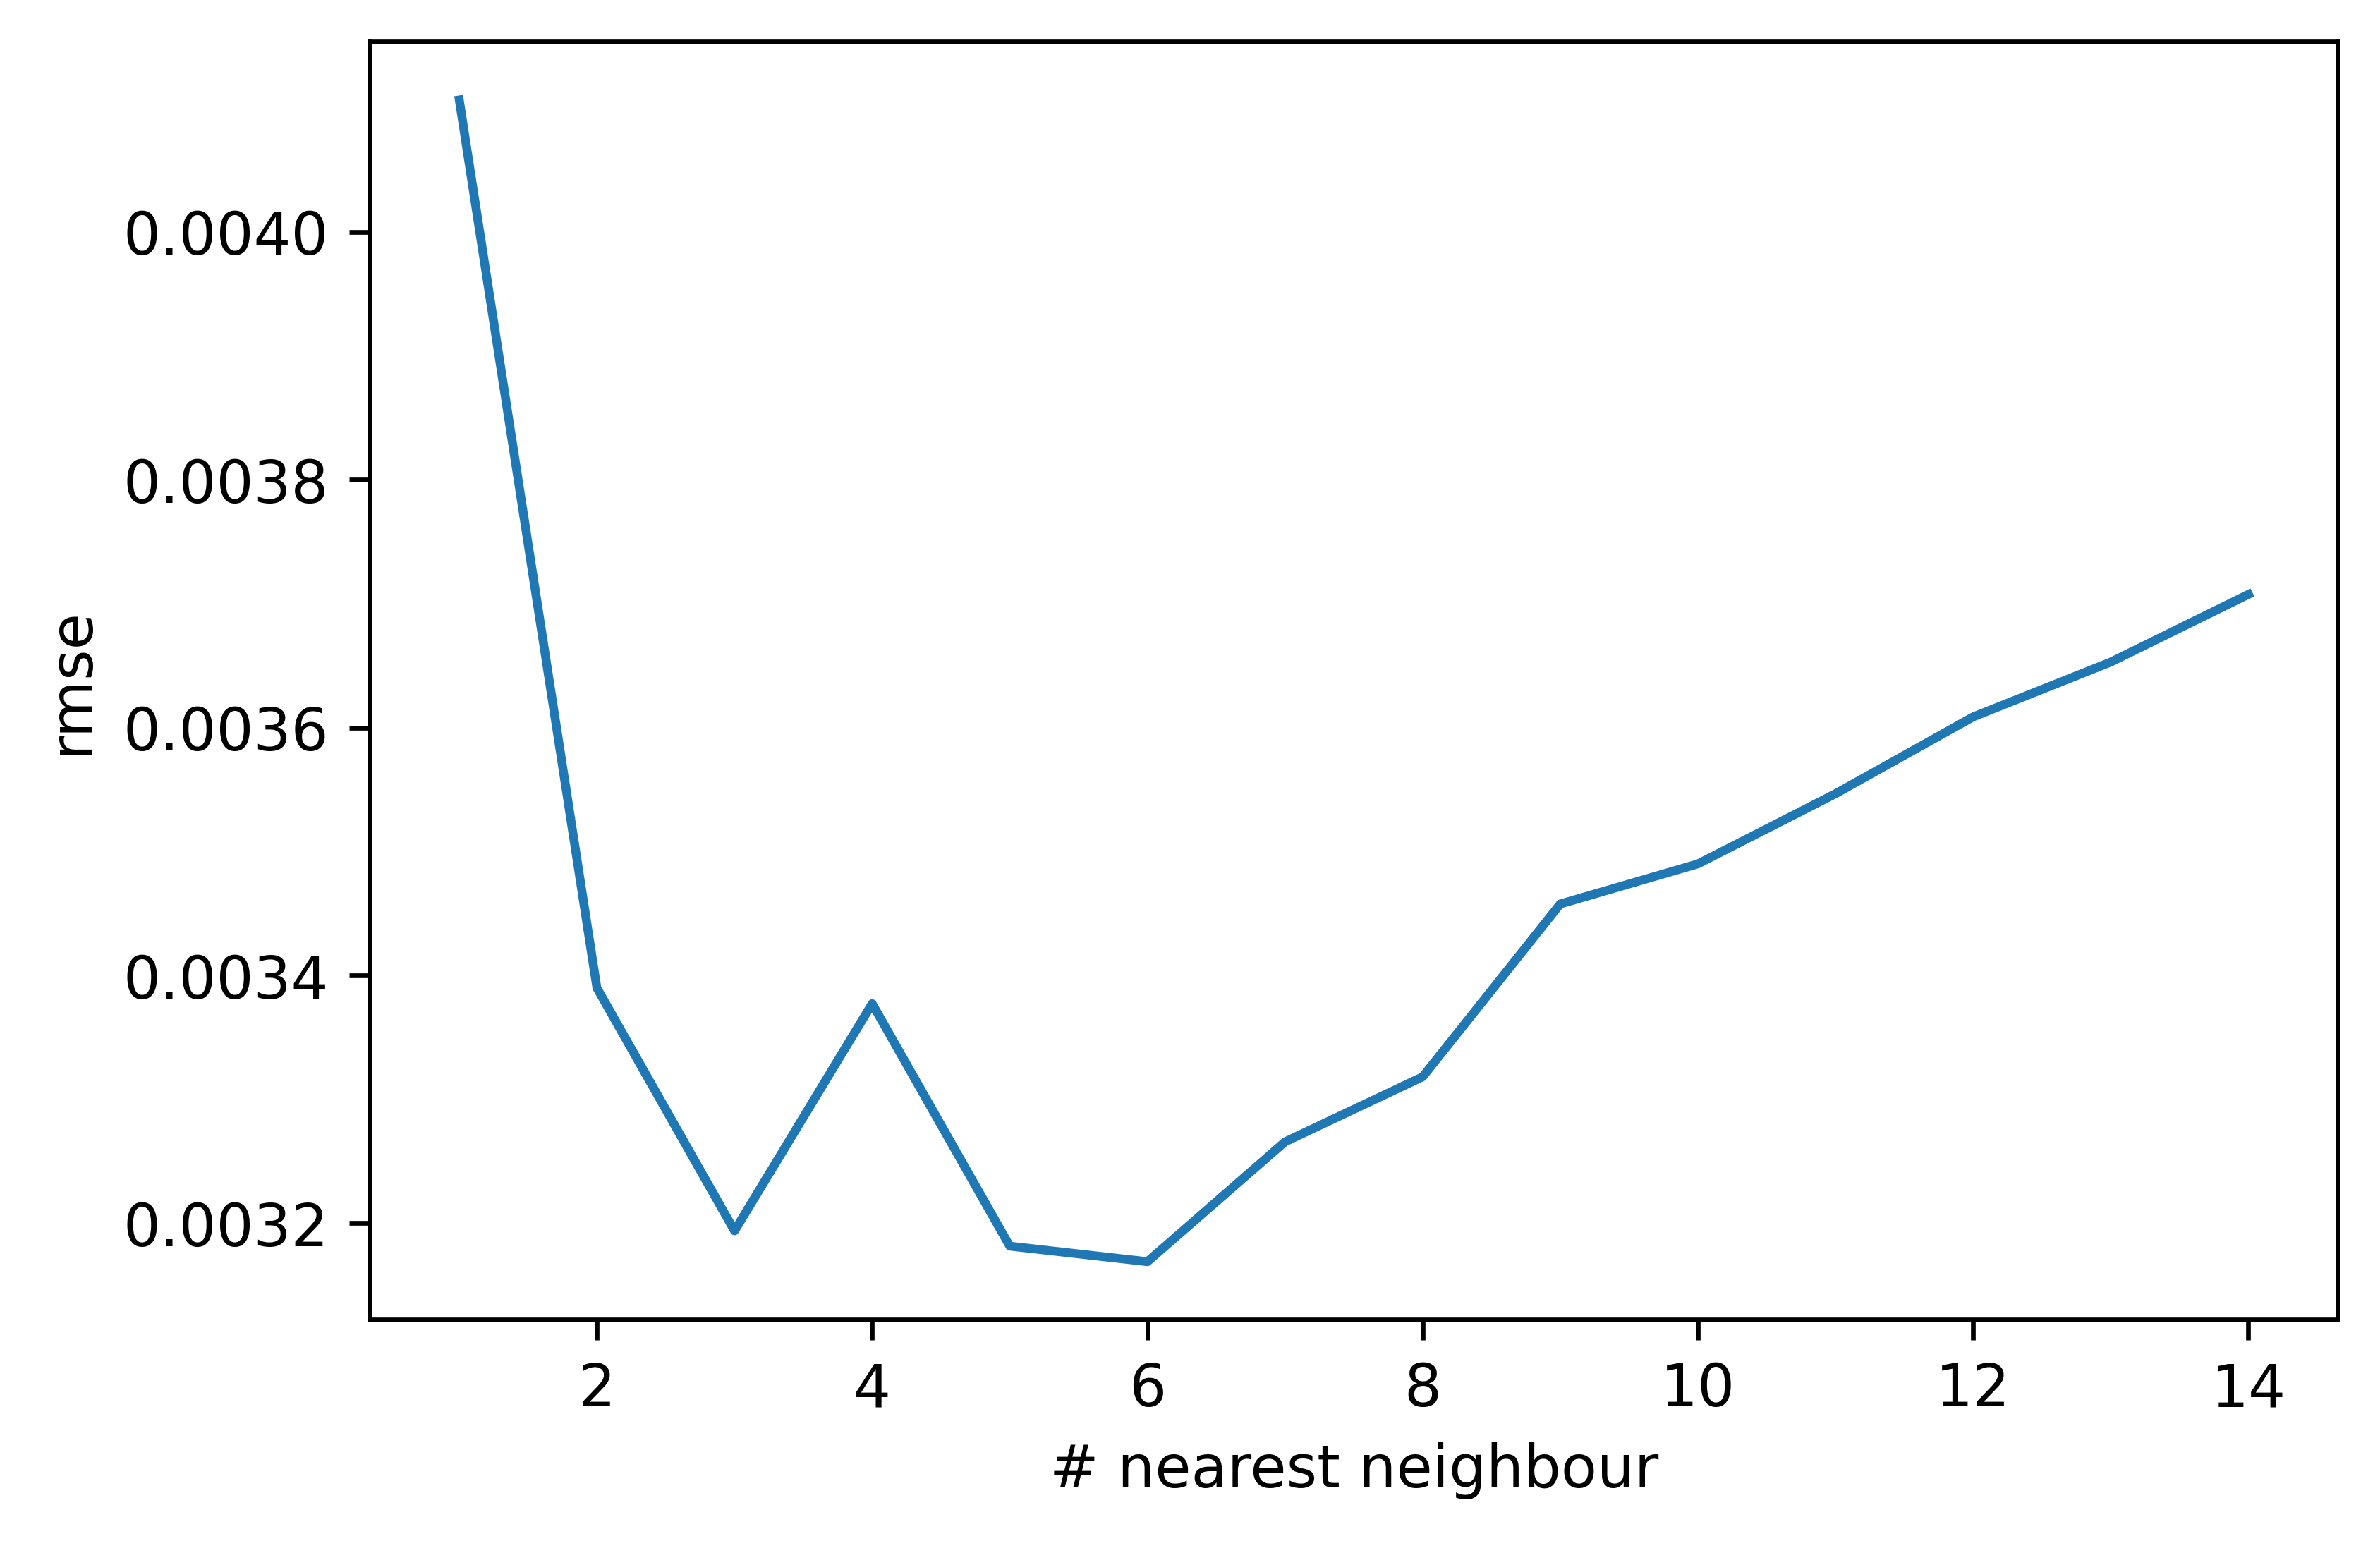

In [51]:
from sklearn.neighbors import KNeighborsRegressor as Knn

## With a small-ish dataset, the best performing k-value is found for the test set
## rather than optimising a validation set or the whole training set
n_levels = 15
candidate_rmse = []
for i in range(1,n_levels):
    knn_model = Knn(i)
    knn_model.fit(x_train,y_train)
    candidate_rmse.append(rmse(knn_model.predict(x_test),y_test))
n = np.array(candidate_rmse).argmin() + 1
print(n)
plt.plot(range(1,n_levels),candidate_rmse)
plt.ylabel('rmse')
plt.xlabel('# nearest neighbour')
pass

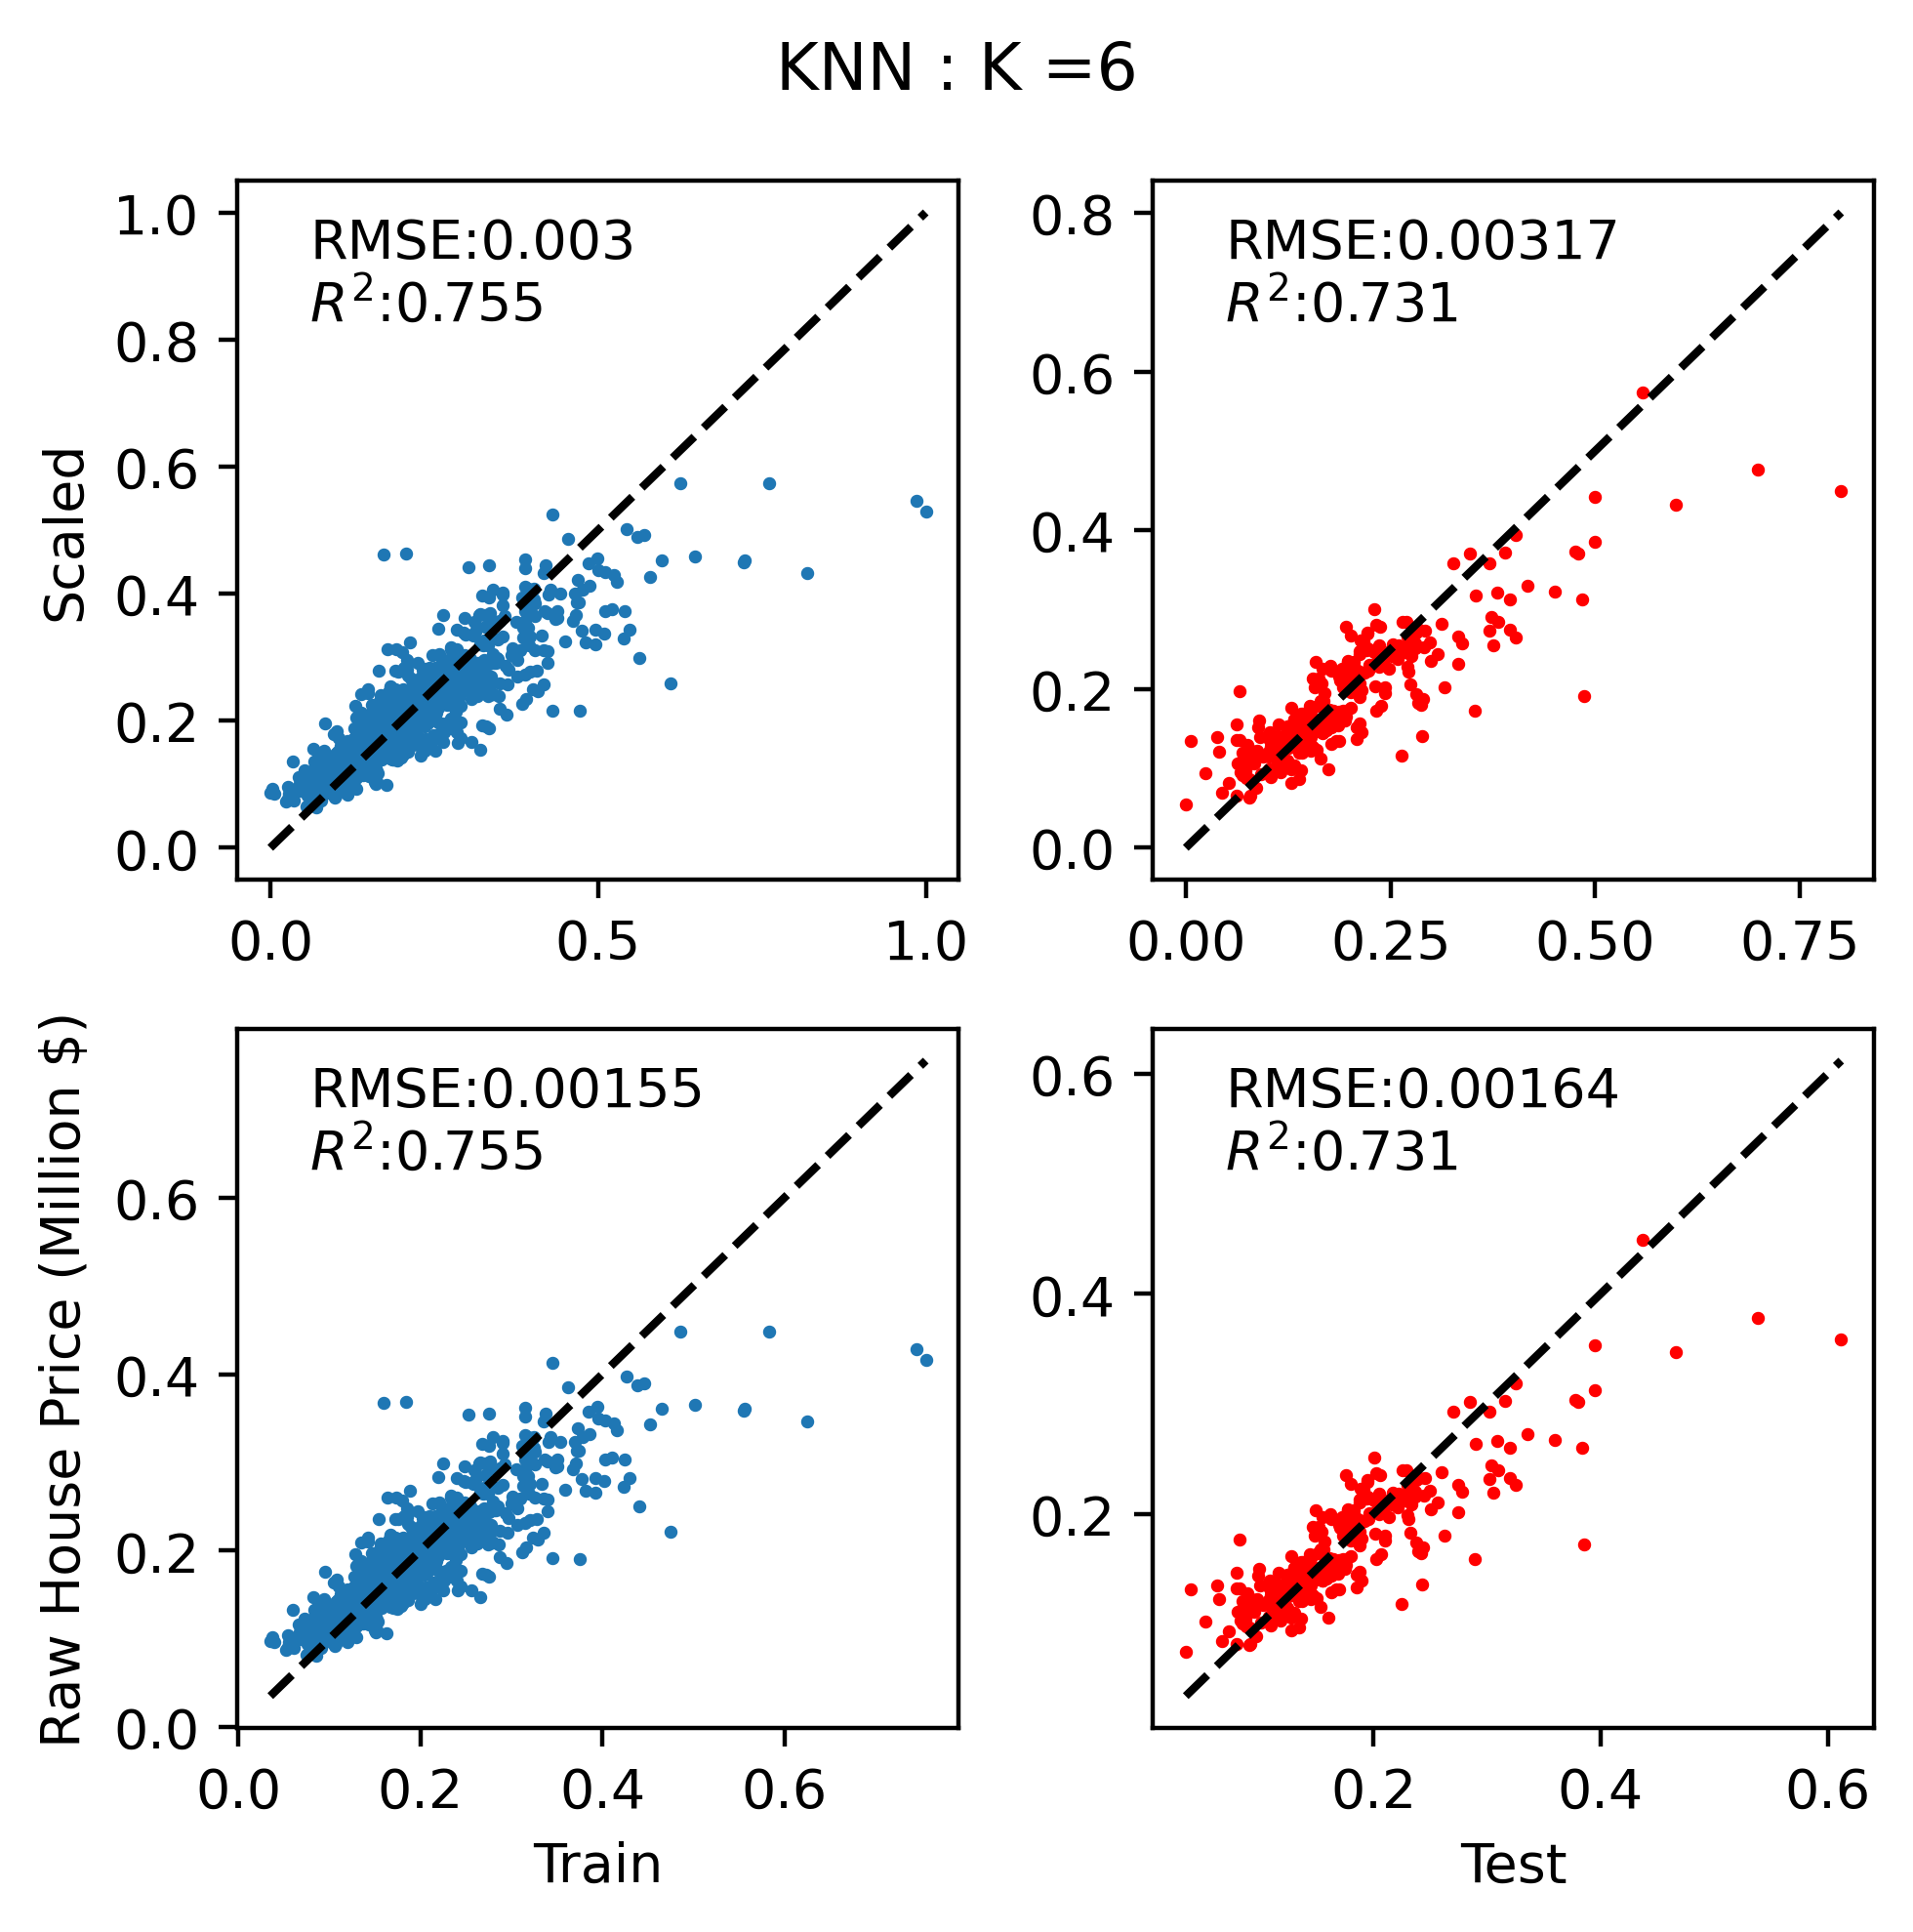

In [52]:
knn_model = Knn(n)
knn_model.fit(x_train,y_train)
row = quartet_plot(knn_model,title = "KNN : K =" + str(n))
results = results.append(row)

# Ensemble / Boosting

## Random Forest

Random Forests are a great general form of regressor and classifier, robust to many different data types and highly tunable. While a grid search would comprise all possible values, there are many values to tune and for speed this will be tuned through a random grid search.

In [53]:
from sklearn.ensemble import RandomForestRegressor as Rfr

In [54]:
%%time
from sklearn.model_selection import RandomizedSearchCV


## Bootstrapping left as True by default, 5-fold cross val is used by default by random grid search
parameters = {#'criterion' : ['mse'],
              'n_estimators' : np.arange(20,300,20),
              'max_depth' : np.arange(5,150,5),
              'max_features' : np.arange(10,200,20),
              'min_samples_split' : [2,4,6,8]
             }
cand_rfr = Rfr()
Random_rfr = RandomizedSearchCV(cand_rfr,parameters,n_jobs = 10,verbose = 1,n_iter = 500)
Random_rfr.fit(x_train,y_train.ravel())
print()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

CPU times: user 3.01 s, sys: 217 ms, total: 3.23 s
Wall time: 3min 59s


In [55]:
res = pd.DataFrame(Random_rfr.cv_results_)
res.drop(columns = ['std_fit_time','mean_score_time','std_score_time','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','std_test_score'],inplace = True)
res['mean_test_score'].max()

0.8645175292537755

In [56]:
import seaborn as sns
## Only selecting a subset of the larger df that is relavent for the plots
df = res[["param_n_estimators","param_max_depth","param_max_features","param_min_samples_split","mean_test_score"]].copy()
## Convert dtypes to numeric
for column in df.columns:
    df[column] = pd.to_numeric(df[column])
sns.pairplot(df,corner = True,diag_kind="kde")
print()

The upper plots in the grid show that the parameter grid has been sampled effectively across much of the possible parameter combinations possible. The last row shows how each individual parameter relates to the outcome rmse performance. It is hard to make out much of a difference across each parameter, and there is no clear evidence that the boundaries of the parameter grid should be expanded to allow for more possible hyperparameter combinations.

Looking at the bottom right plot, the kde plot of the mean_test_score, we see that many of the models performed very well at about 85% accuracy (on train set).

In [57]:
Random_rfr.best_params_

{'n_estimators': 80,
 'min_samples_split': 2,
 'max_features': 70,
 'max_depth': 120}

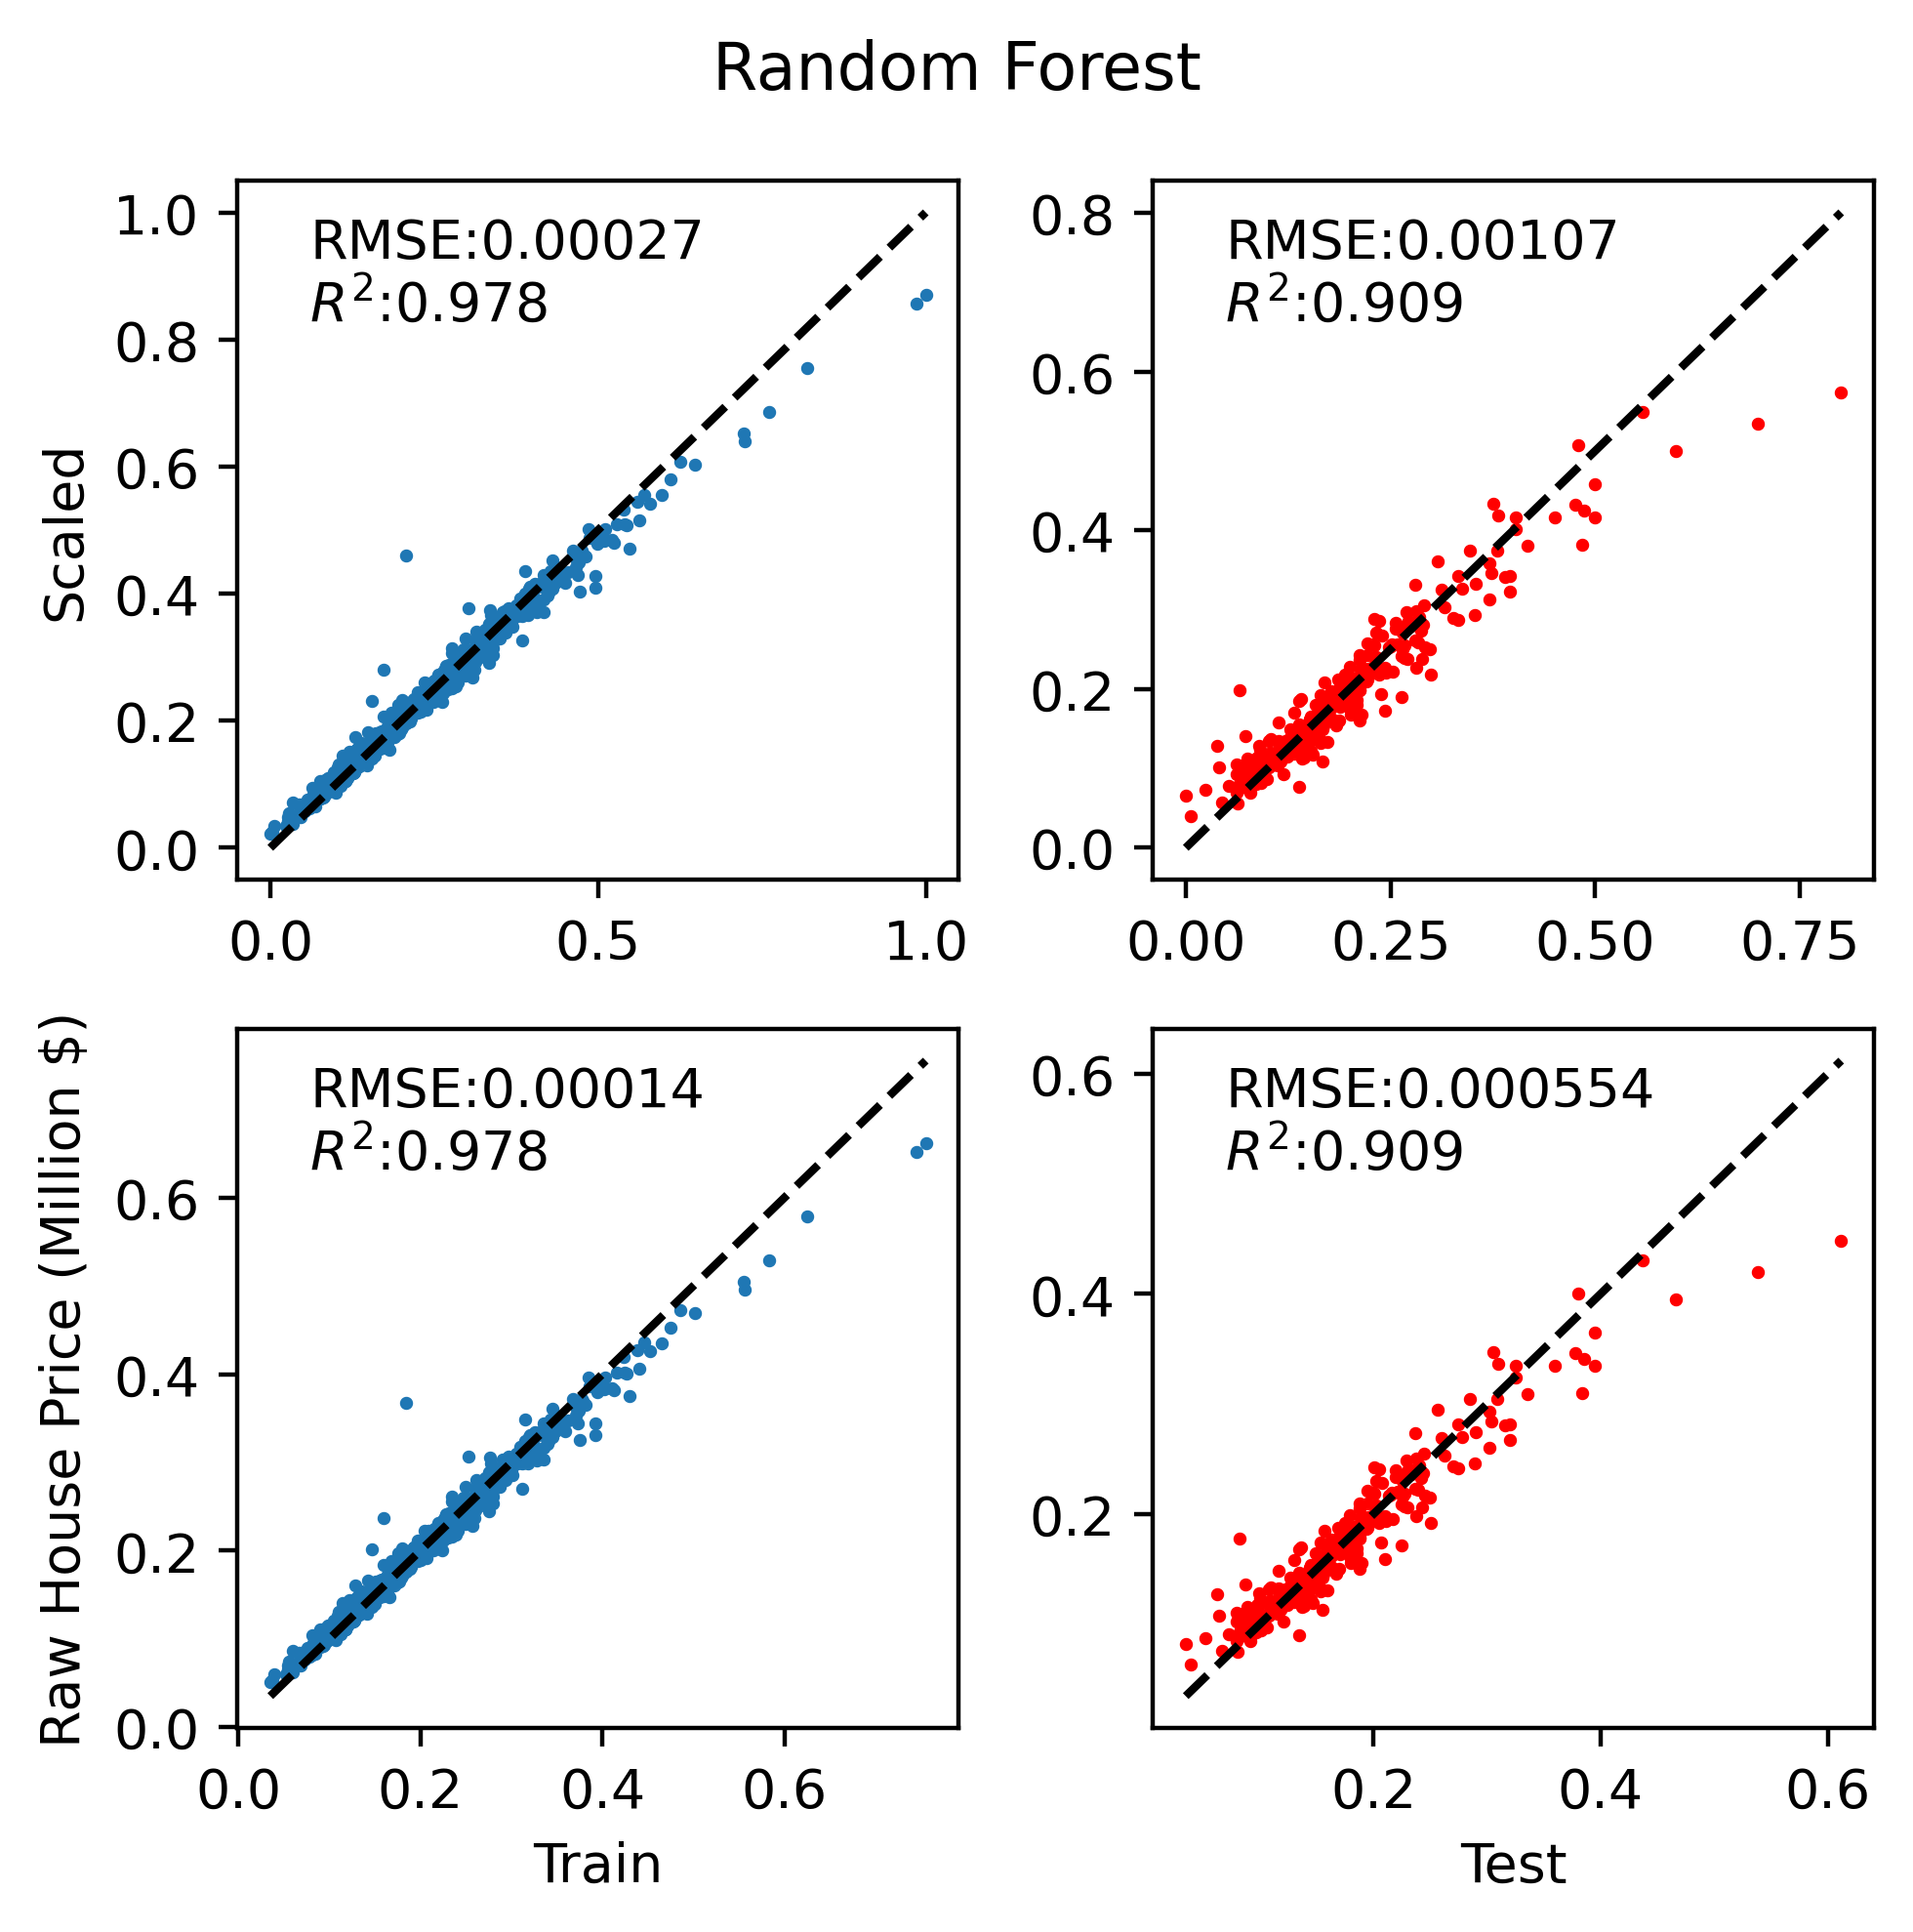

In [58]:
params = Random_rfr.best_params_
RF_model = Rfr(**params)
RF_model.fit(x_train,y_train.ravel())
row = quartet_plot(RF_model,title = 'Random Forest')
results = results.append(row)

## Adaboost

In [59]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [60]:
%%time
from sklearn.model_selection import RandomizedSearchCV


## Bootstrapping left as True by default, 5-fold cross val is used by default by random grid search
parameters = {'base_estimator' : [DecisionTreeRegressor(max_depth = depth) for depth in [1,2,3,5,7,9,12]],
              'n_estimators' : np.arange(10,100,10),
              'learning_rate' : np.arange(0.1,1,0.05),
              'loss' : ["linear", "square", "exponential"],
             }
cand_AdaBoost = AdaBoostRegressor()
Random_AdaBoost = RandomizedSearchCV(cand_AdaBoost,parameters,n_jobs = 10,verbose = 1,n_iter = 500)
Random_AdaBoost.fit(x_train,y_train.ravel())
print()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

CPU times: user 3.12 s, sys: 124 ms, total: 3.25 s
Wall time: 1min 54s


In [61]:
res = pd.DataFrame(Random_AdaBoost.cv_results_)
res.drop(columns = ['std_fit_time','mean_score_time','std_score_time','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','std_test_score'],inplace = True)
res['mean_test_score'].max()

0.8699622770049082

In [62]:
## Need to define the max_depth parameter from the trees explicitly
res['param_max_depth'] = [tree.max_depth for tree in res['param_base_estimator']]

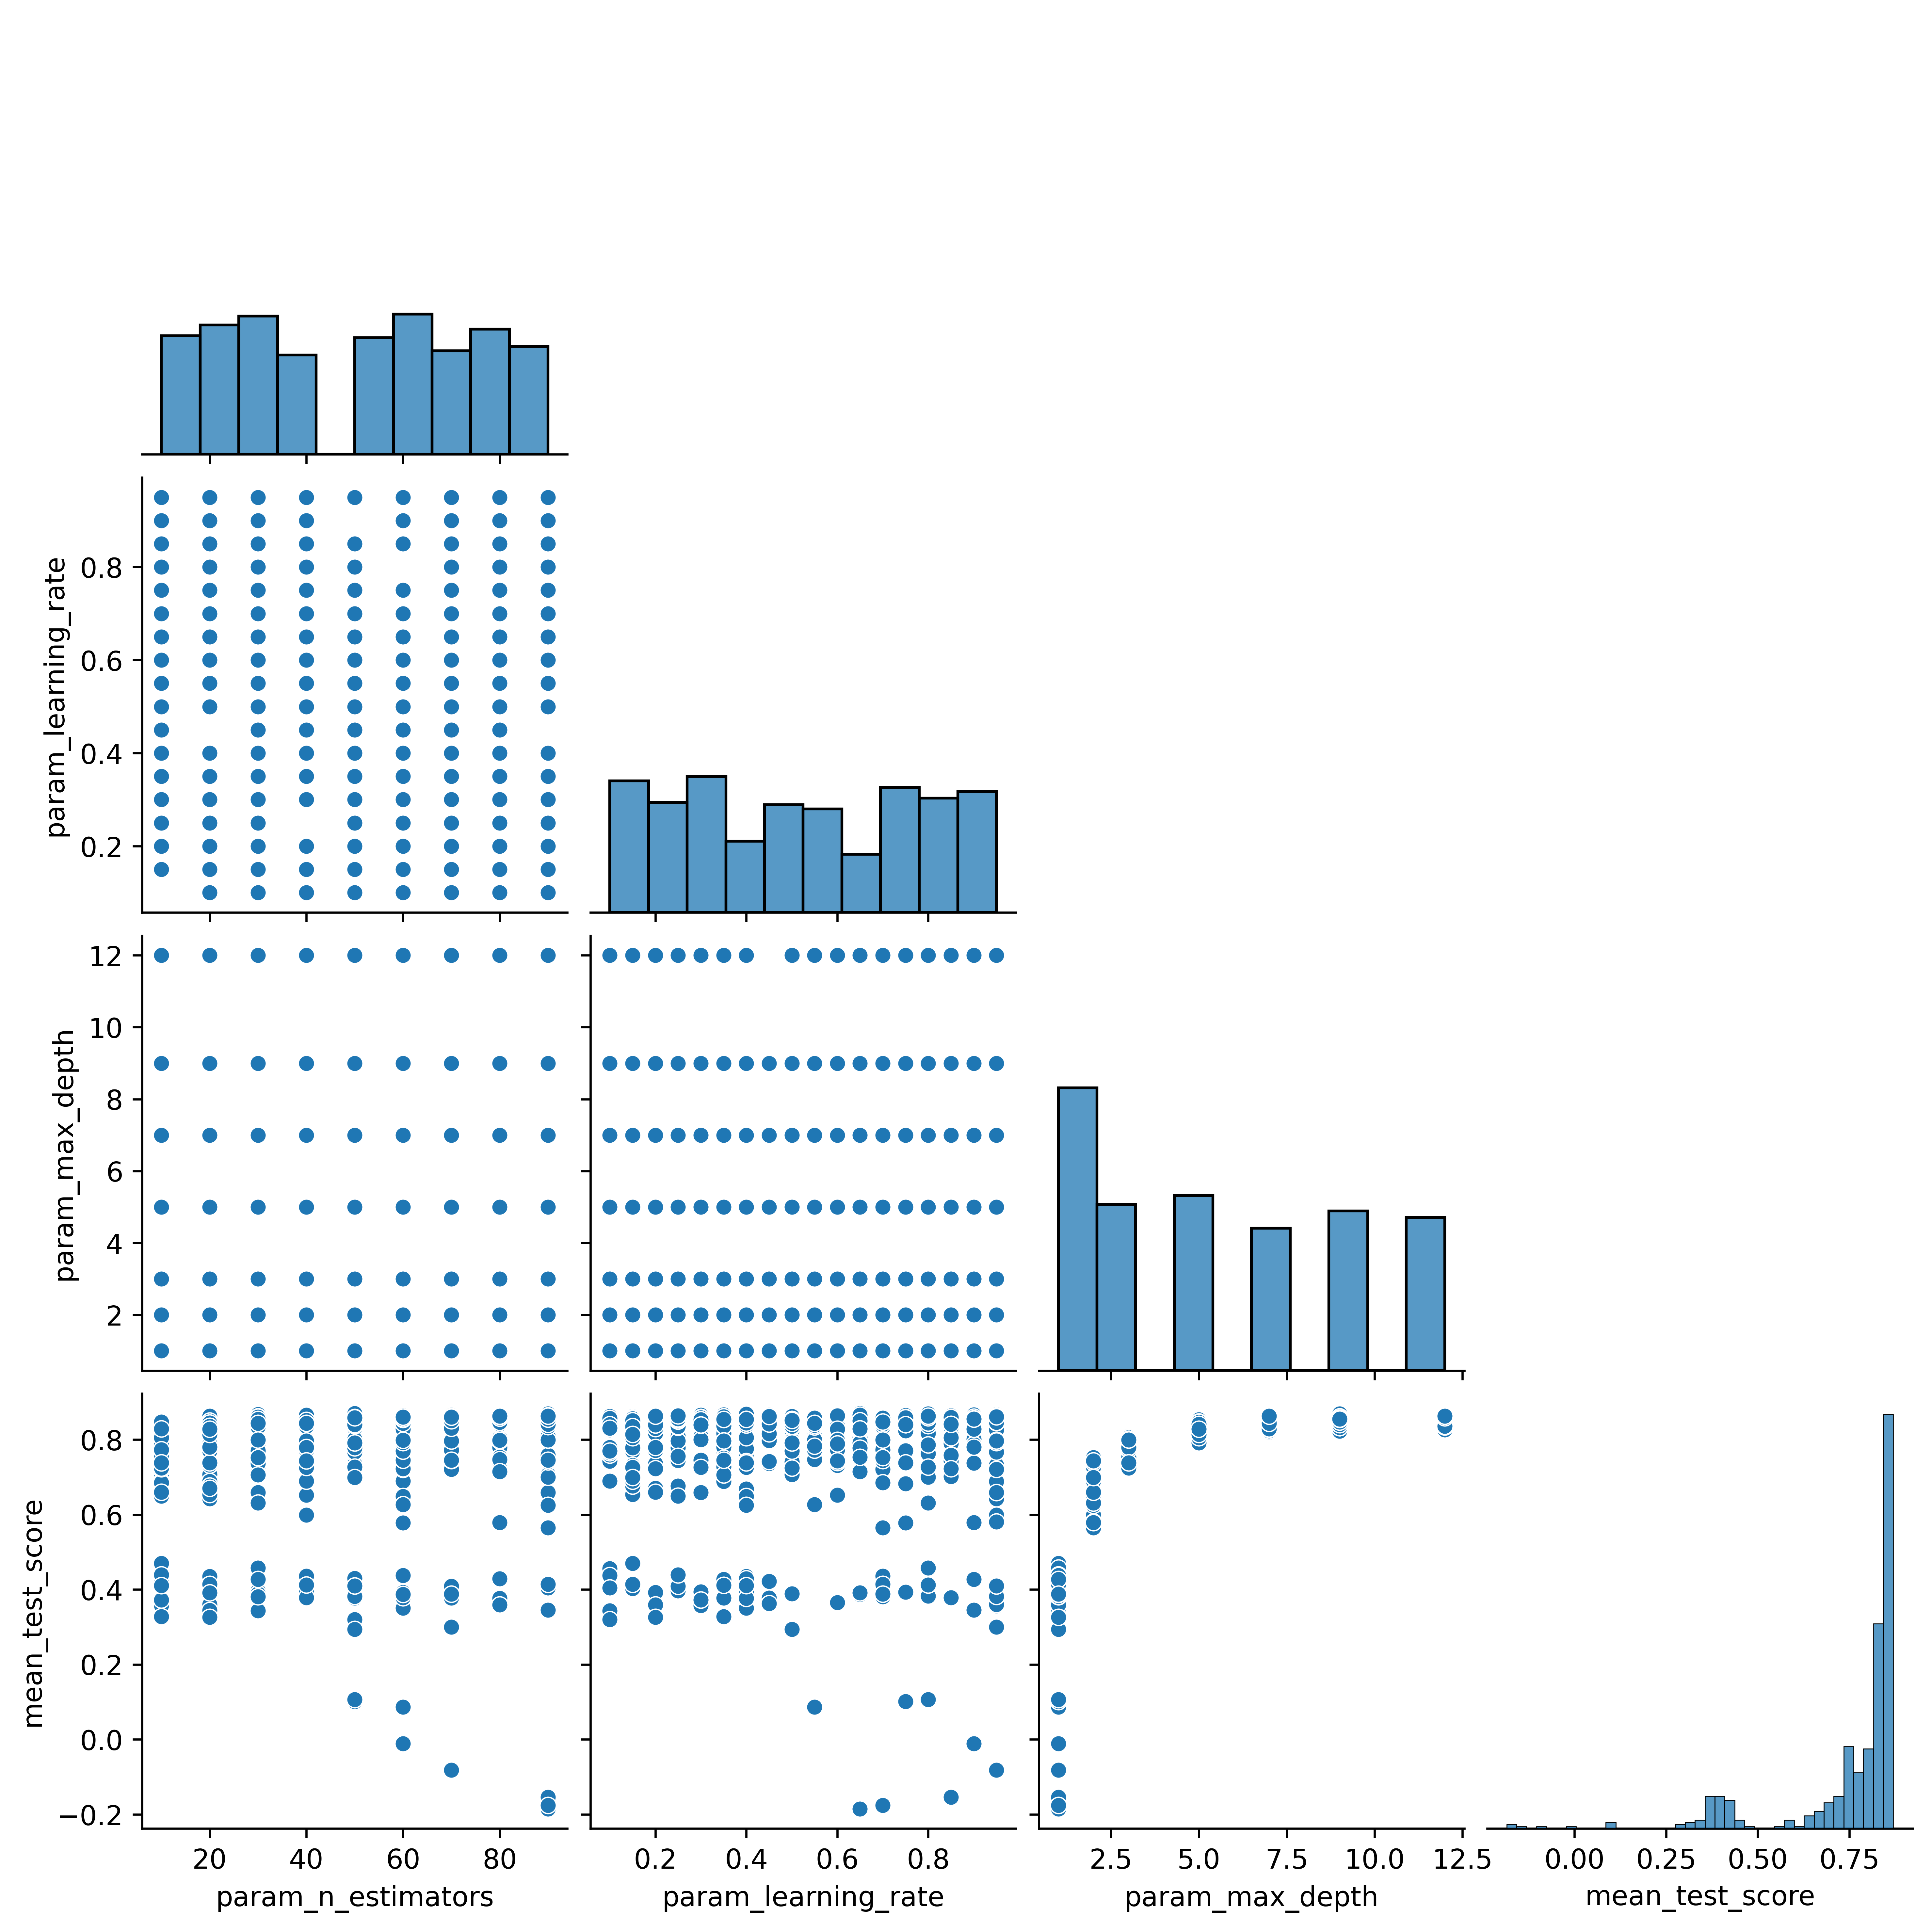

In [63]:
df = res[['param_n_estimators','param_loss','param_learning_rate','param_max_depth','mean_test_score']].copy()

for column in df.columns:
    ## Skip param_loss as this is not numeric
    if column == 'param_loss':
        continue
    df[column] = pd.to_numeric(df[column])
sns.pairplot(df,corner = True)
print()

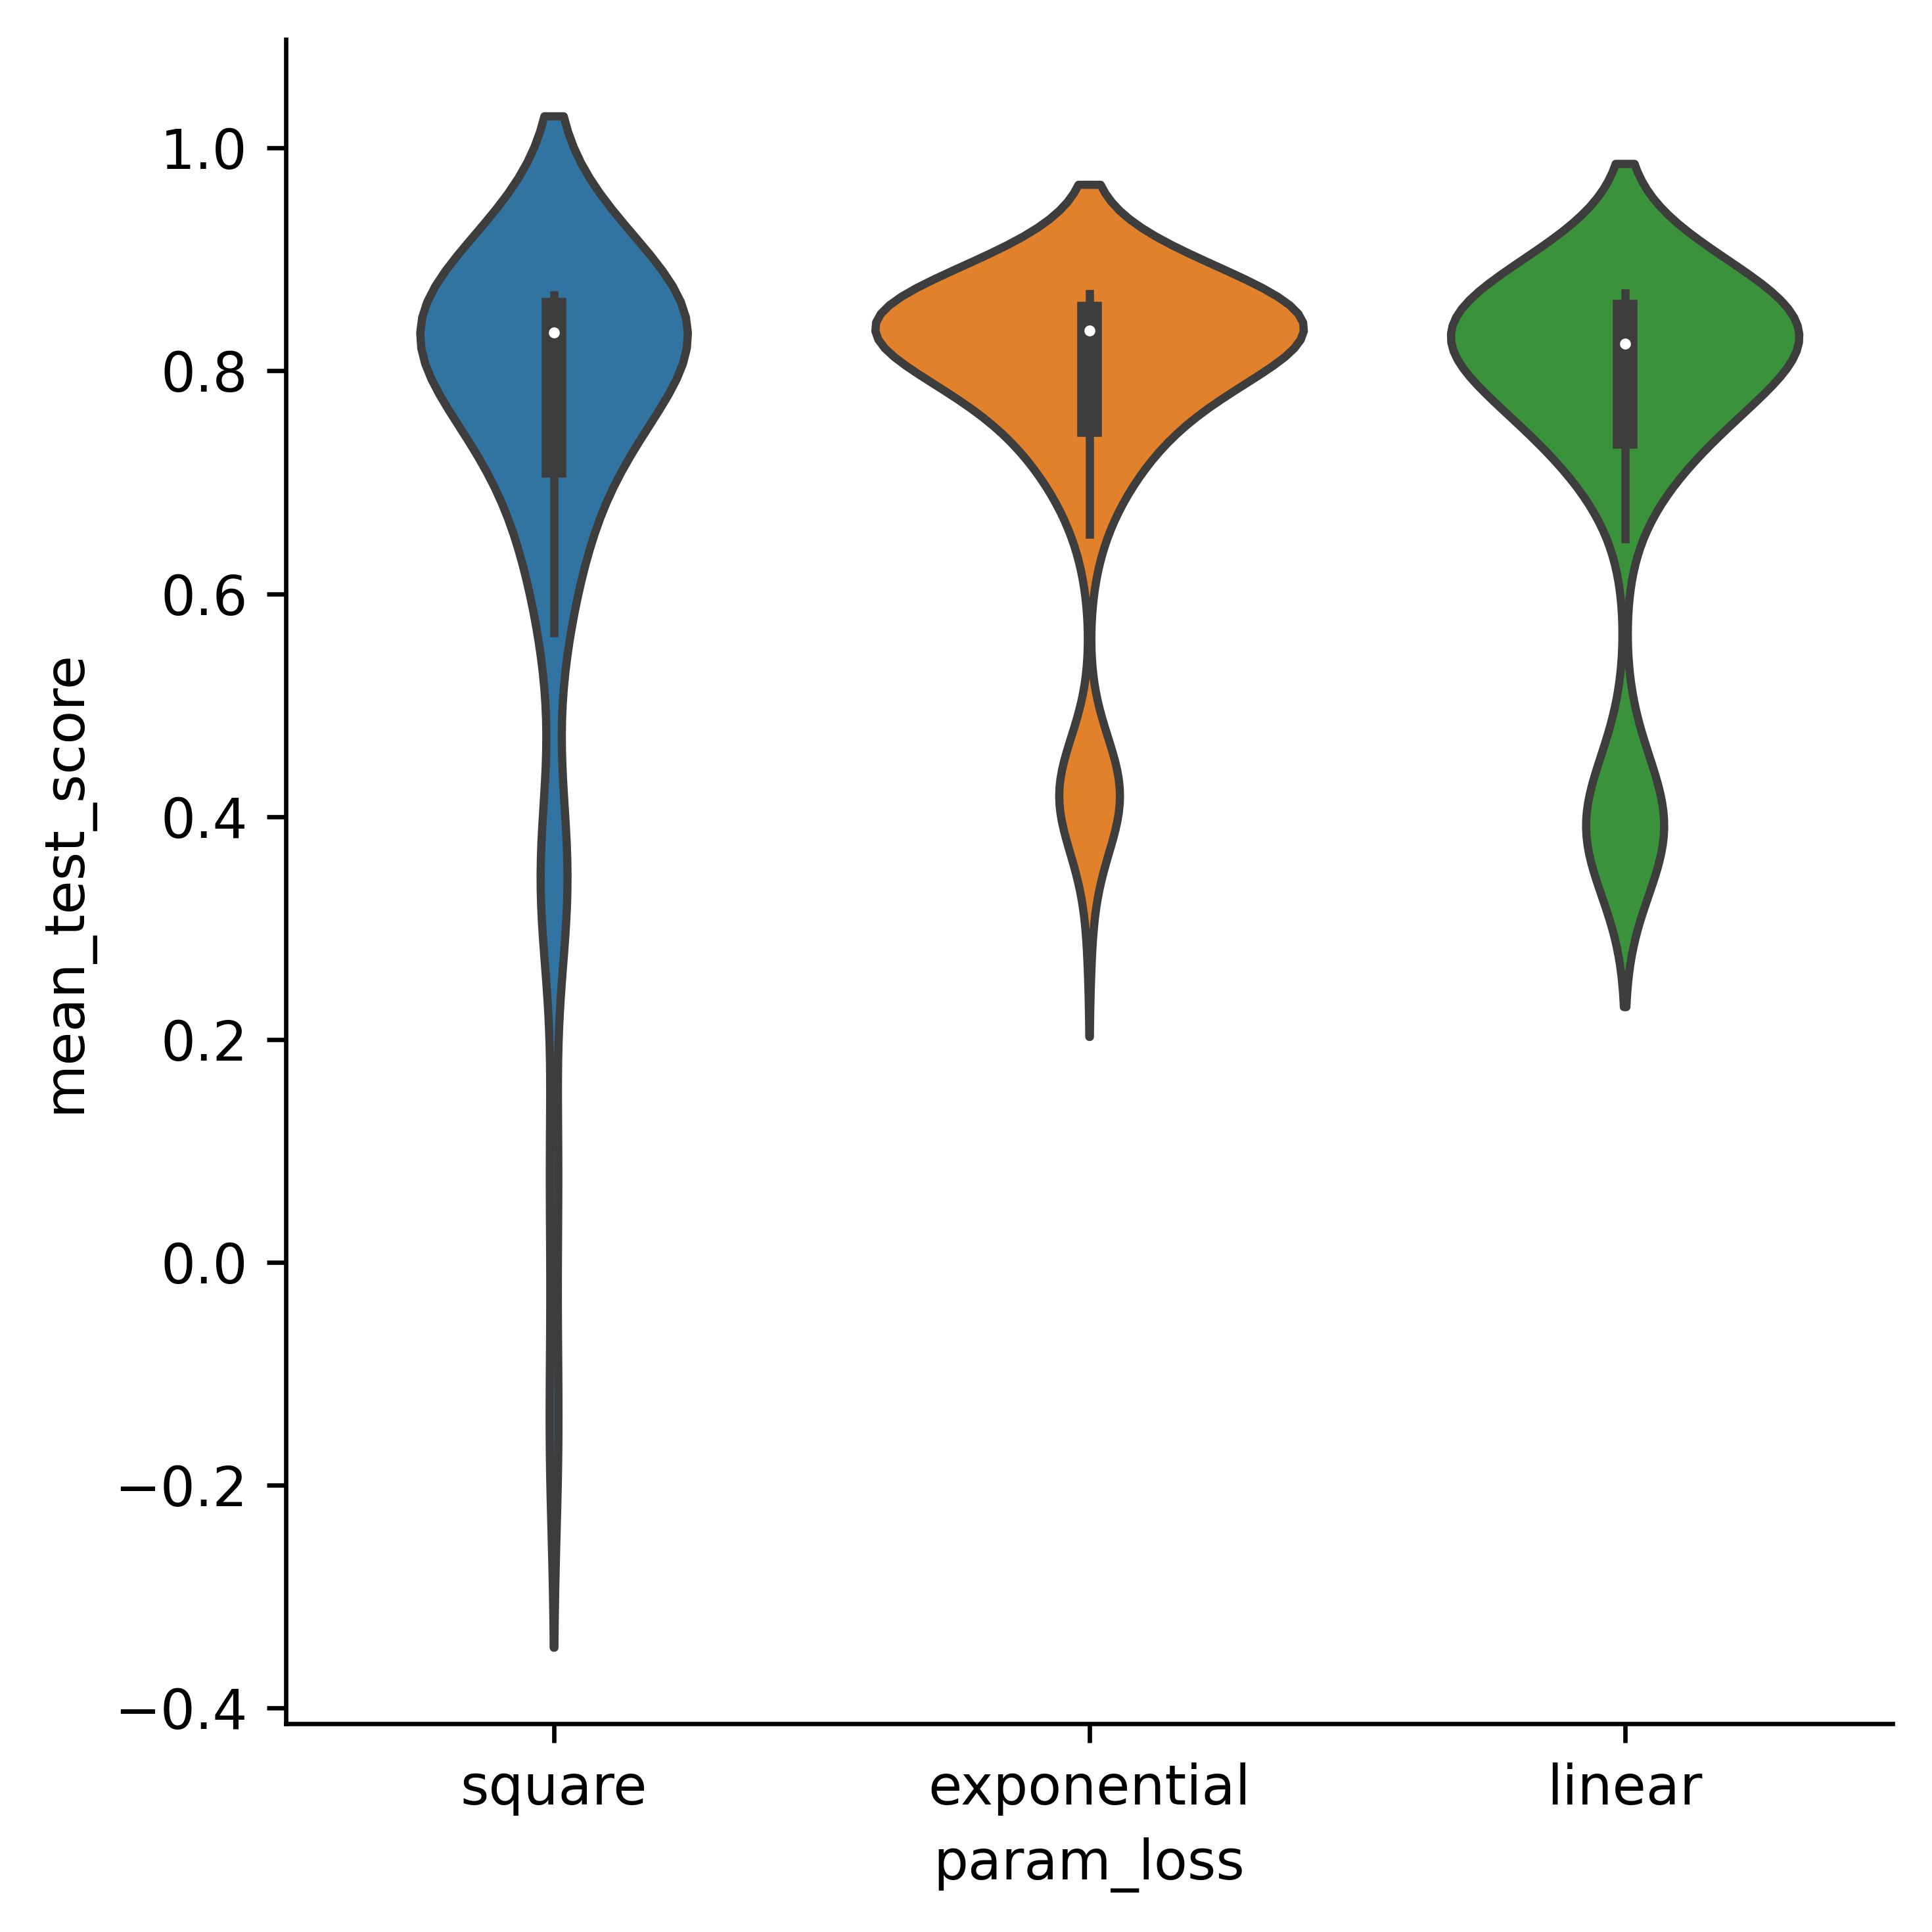

In [64]:
sns.catplot(x="param_loss", y="mean_test_score",
            kind="violin", data=df)
print()

In [65]:
Random_AdaBoost.best_params_

{'n_estimators': 50,
 'loss': 'linear',
 'learning_rate': 0.6500000000000001,
 'base_estimator': DecisionTreeRegressor(max_depth=12)}

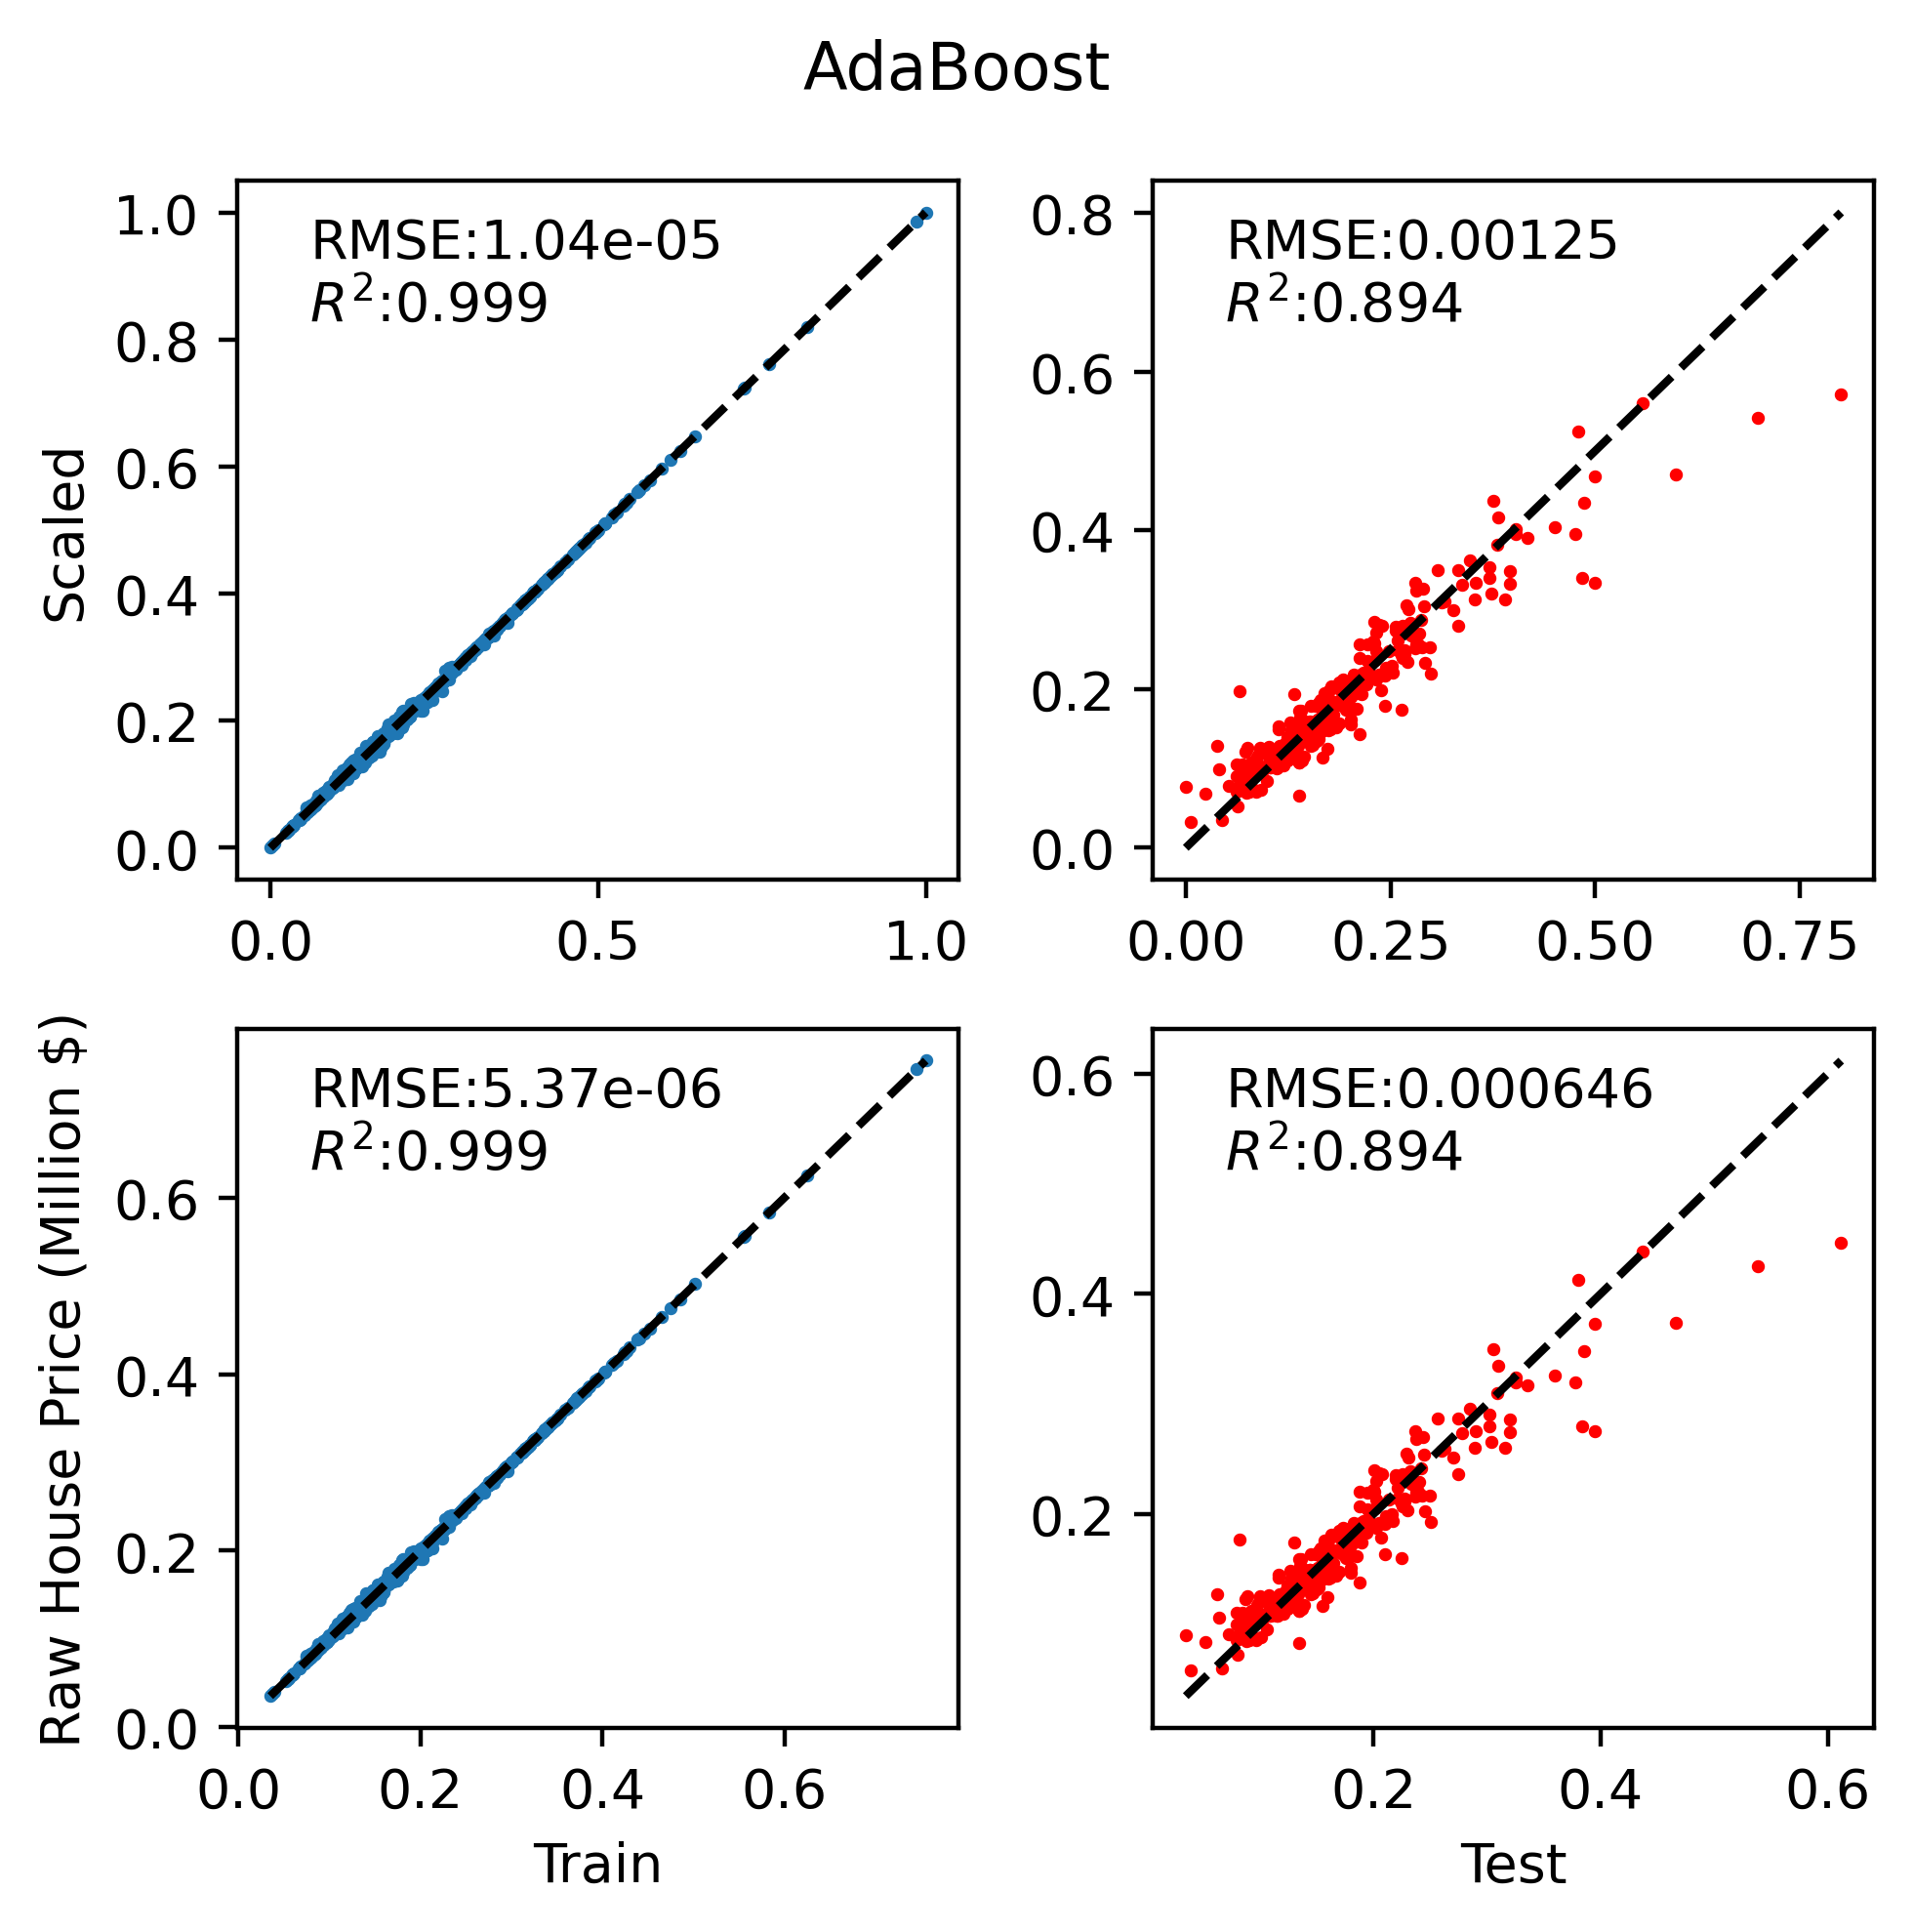

In [66]:
params = Random_AdaBoost.best_params_
AdaBoost_model = AdaBoostRegressor(**params)
AdaBoost_model.fit(x_train,y_train.ravel())
row = quartet_plot(AdaBoost_model,title = "AdaBoost")
results = results.append(row)

Despite the extremely high $R^2$ score on the training dataset, the model still performed well on the test set. It is still slightly overfit but the best model was still chosen (randomly) from the grid of possible values using 5-fold cross validation.

# SVM

For Support Vector Machines it is essential that the data is properly scaled, or else the basis functions don't work properly.

In [67]:
print("min :",x_train.min(),"max :",x_train.max())

min : 0.0 max : 1.0000000000000002


In [68]:
from sklearn.svm import SVR
svr_tab = pd.DataFrame()
for kernel in ['rbf','linear','poly']:
    SVM_model = SVR(kernel = kernel)
    SVM_model.fit(x_train,y_train.ravel())
    row = quartet_plot(SVM_model,title = 'SVM : Kernel = ' + kernel)
    svr_tab = svr_tab.append(row)
    plt.close() # <----- prevent plotting

In [69]:
svr_tab

train_rmse  train_r2  test_rmse   test_r2
svm_:_kernel_=_rbf       0.001257  0.802064   0.001400  0.770194
svm_:_kernel_=_linear    0.001572  0.752363   0.001721  0.717549
svm_:_kernel_=_poly      0.001184  0.813528   0.001340  0.780059

All of the tested (but not thoroughly explored) kernels provide poor $R^2$ scores. SVM's are really more for classification models rather than regression problems, and so this project won't consider them much more past their original hyperparameters.

In [70]:
results = results.append(svr_tab)

# Comparison

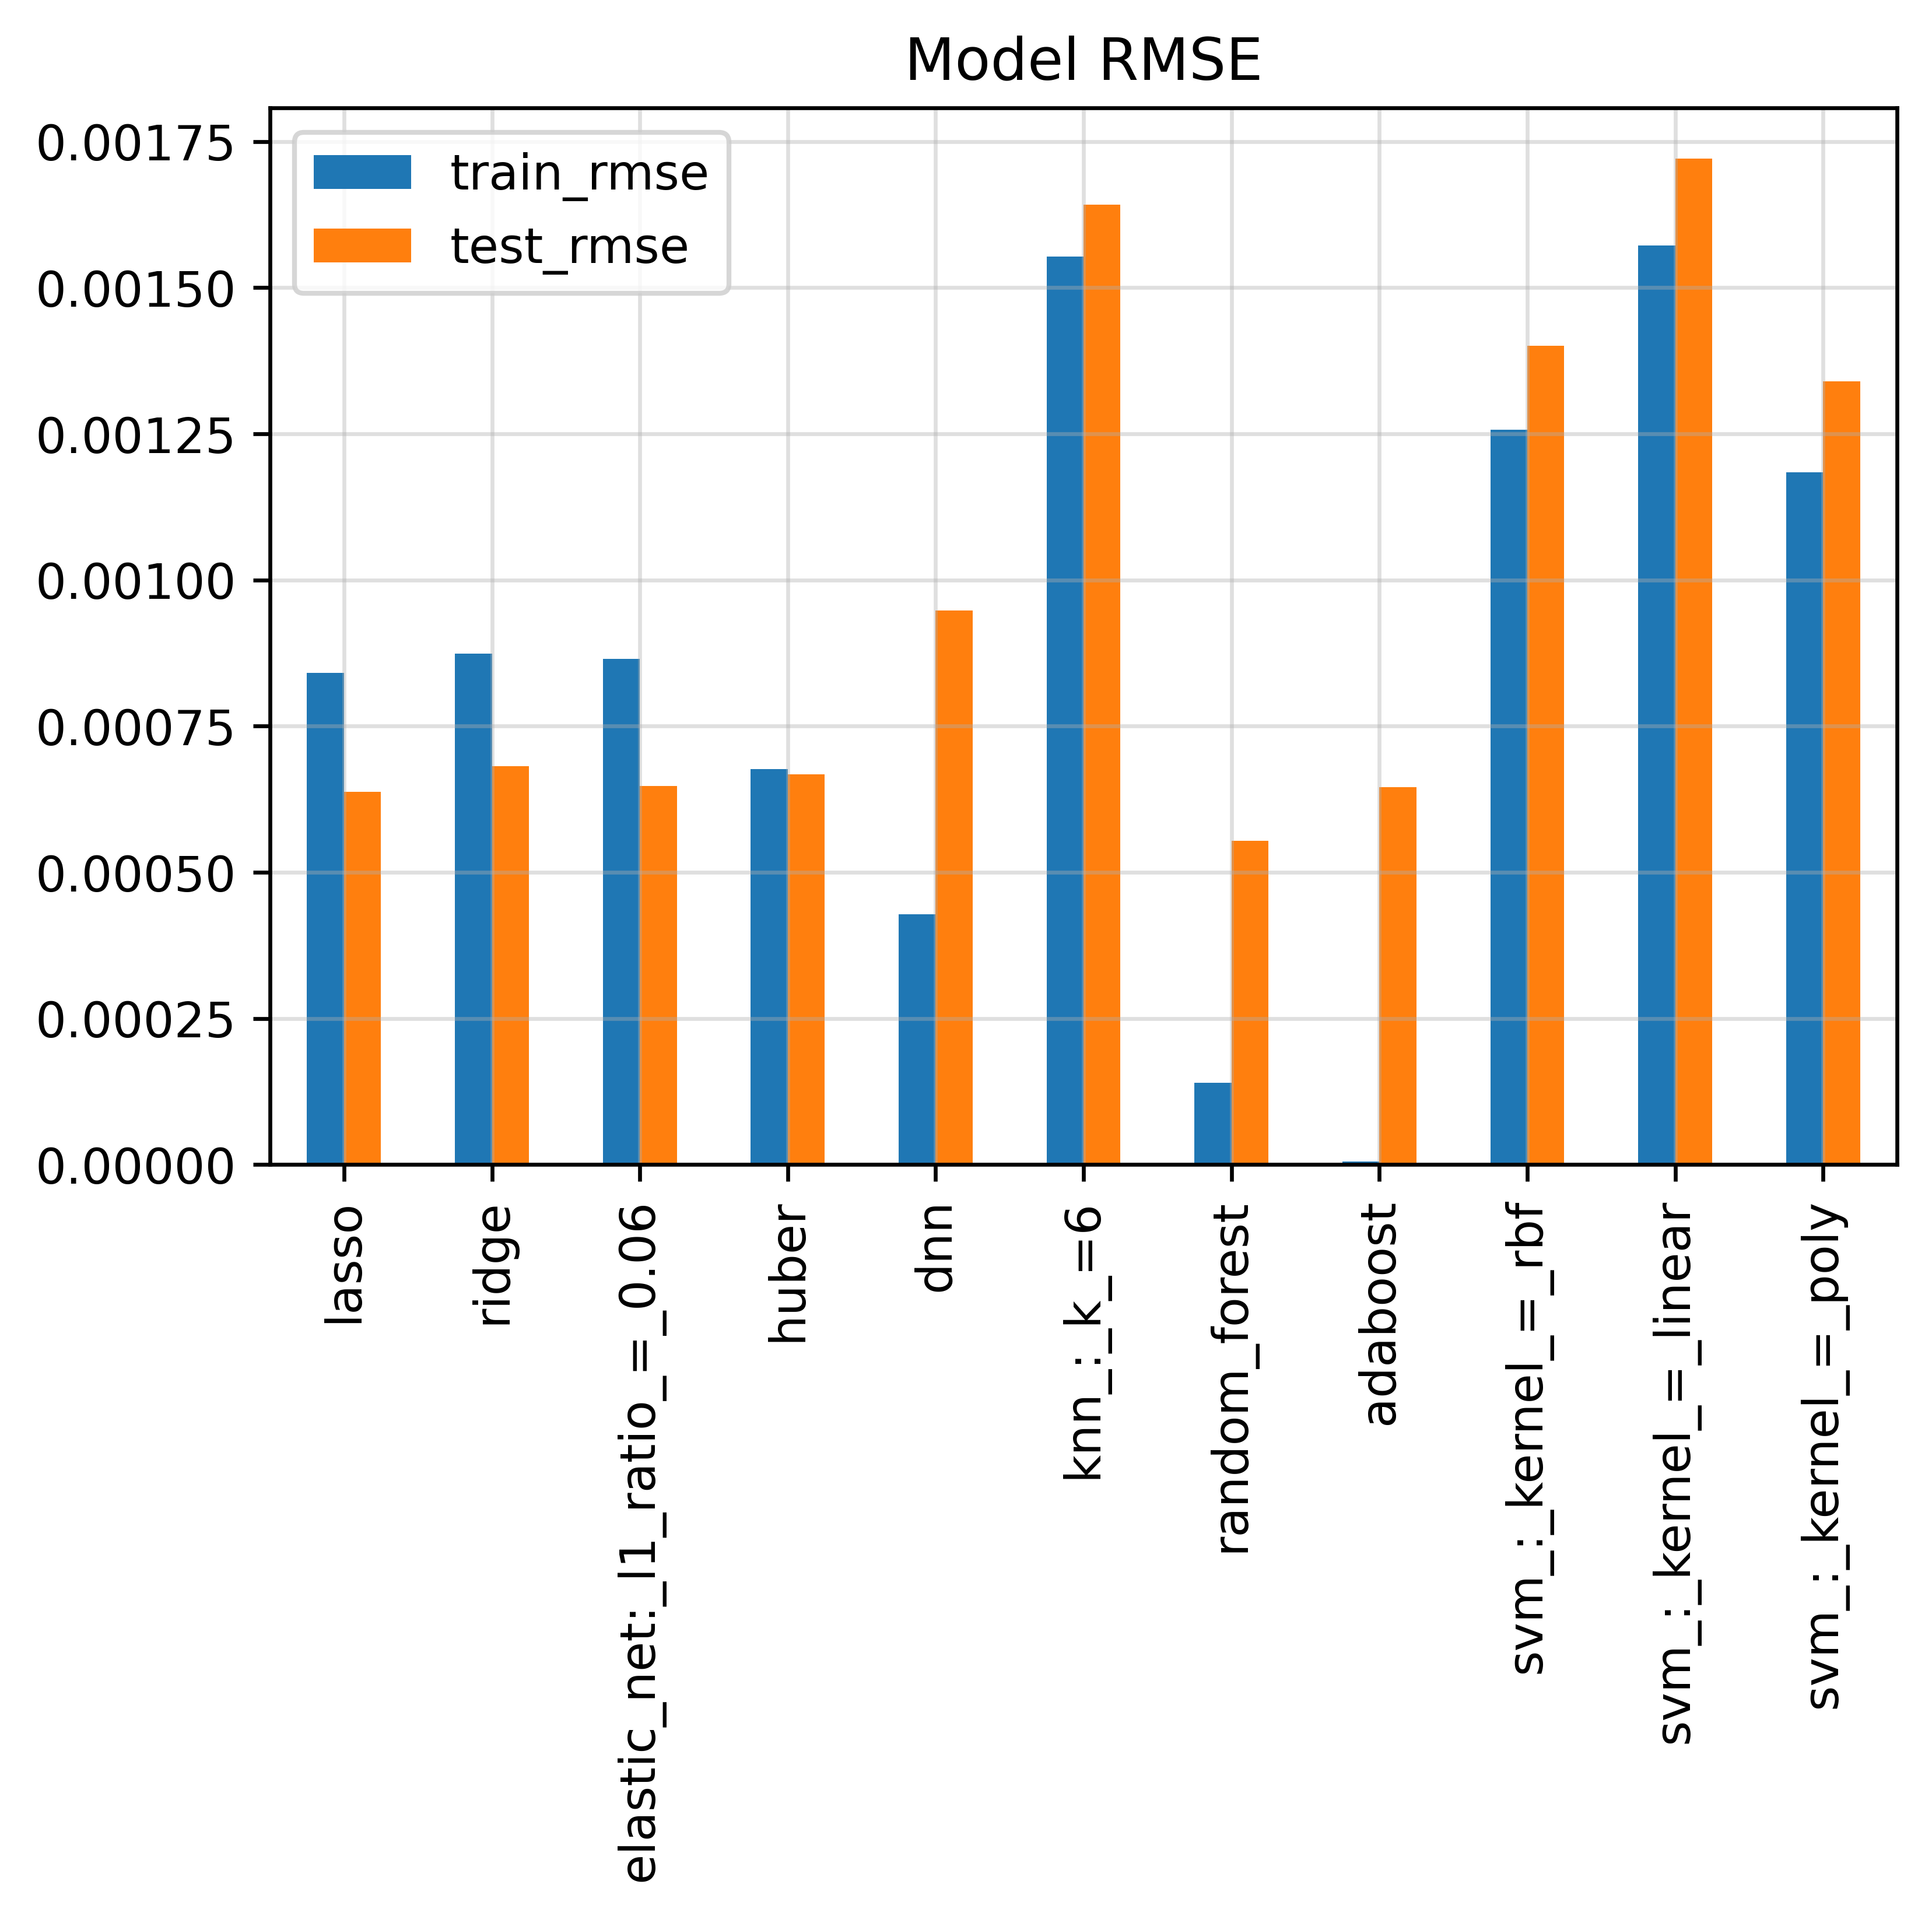

In [76]:
results[['train_rmse','test_rmse']][1:].plot(kind = 'bar',title = "Model RMSE")
plt.grid(alpha = 0.4)
print()

Omitting the first vastly overfitted multiple linear regression model, most models faired quite well. Curiously, the regularized multiple linear regression models had lower test error than train error, although this is possibly due to large outlier residuals. The deep neural netword faired very well, whilst the more classification-focused models understandably underperformed (Knn and SVR). The ensemble methods of random forests and adaboosting did very well, achieving extremely low train accuracy, whilst not overfitting and still achieving a low test error.

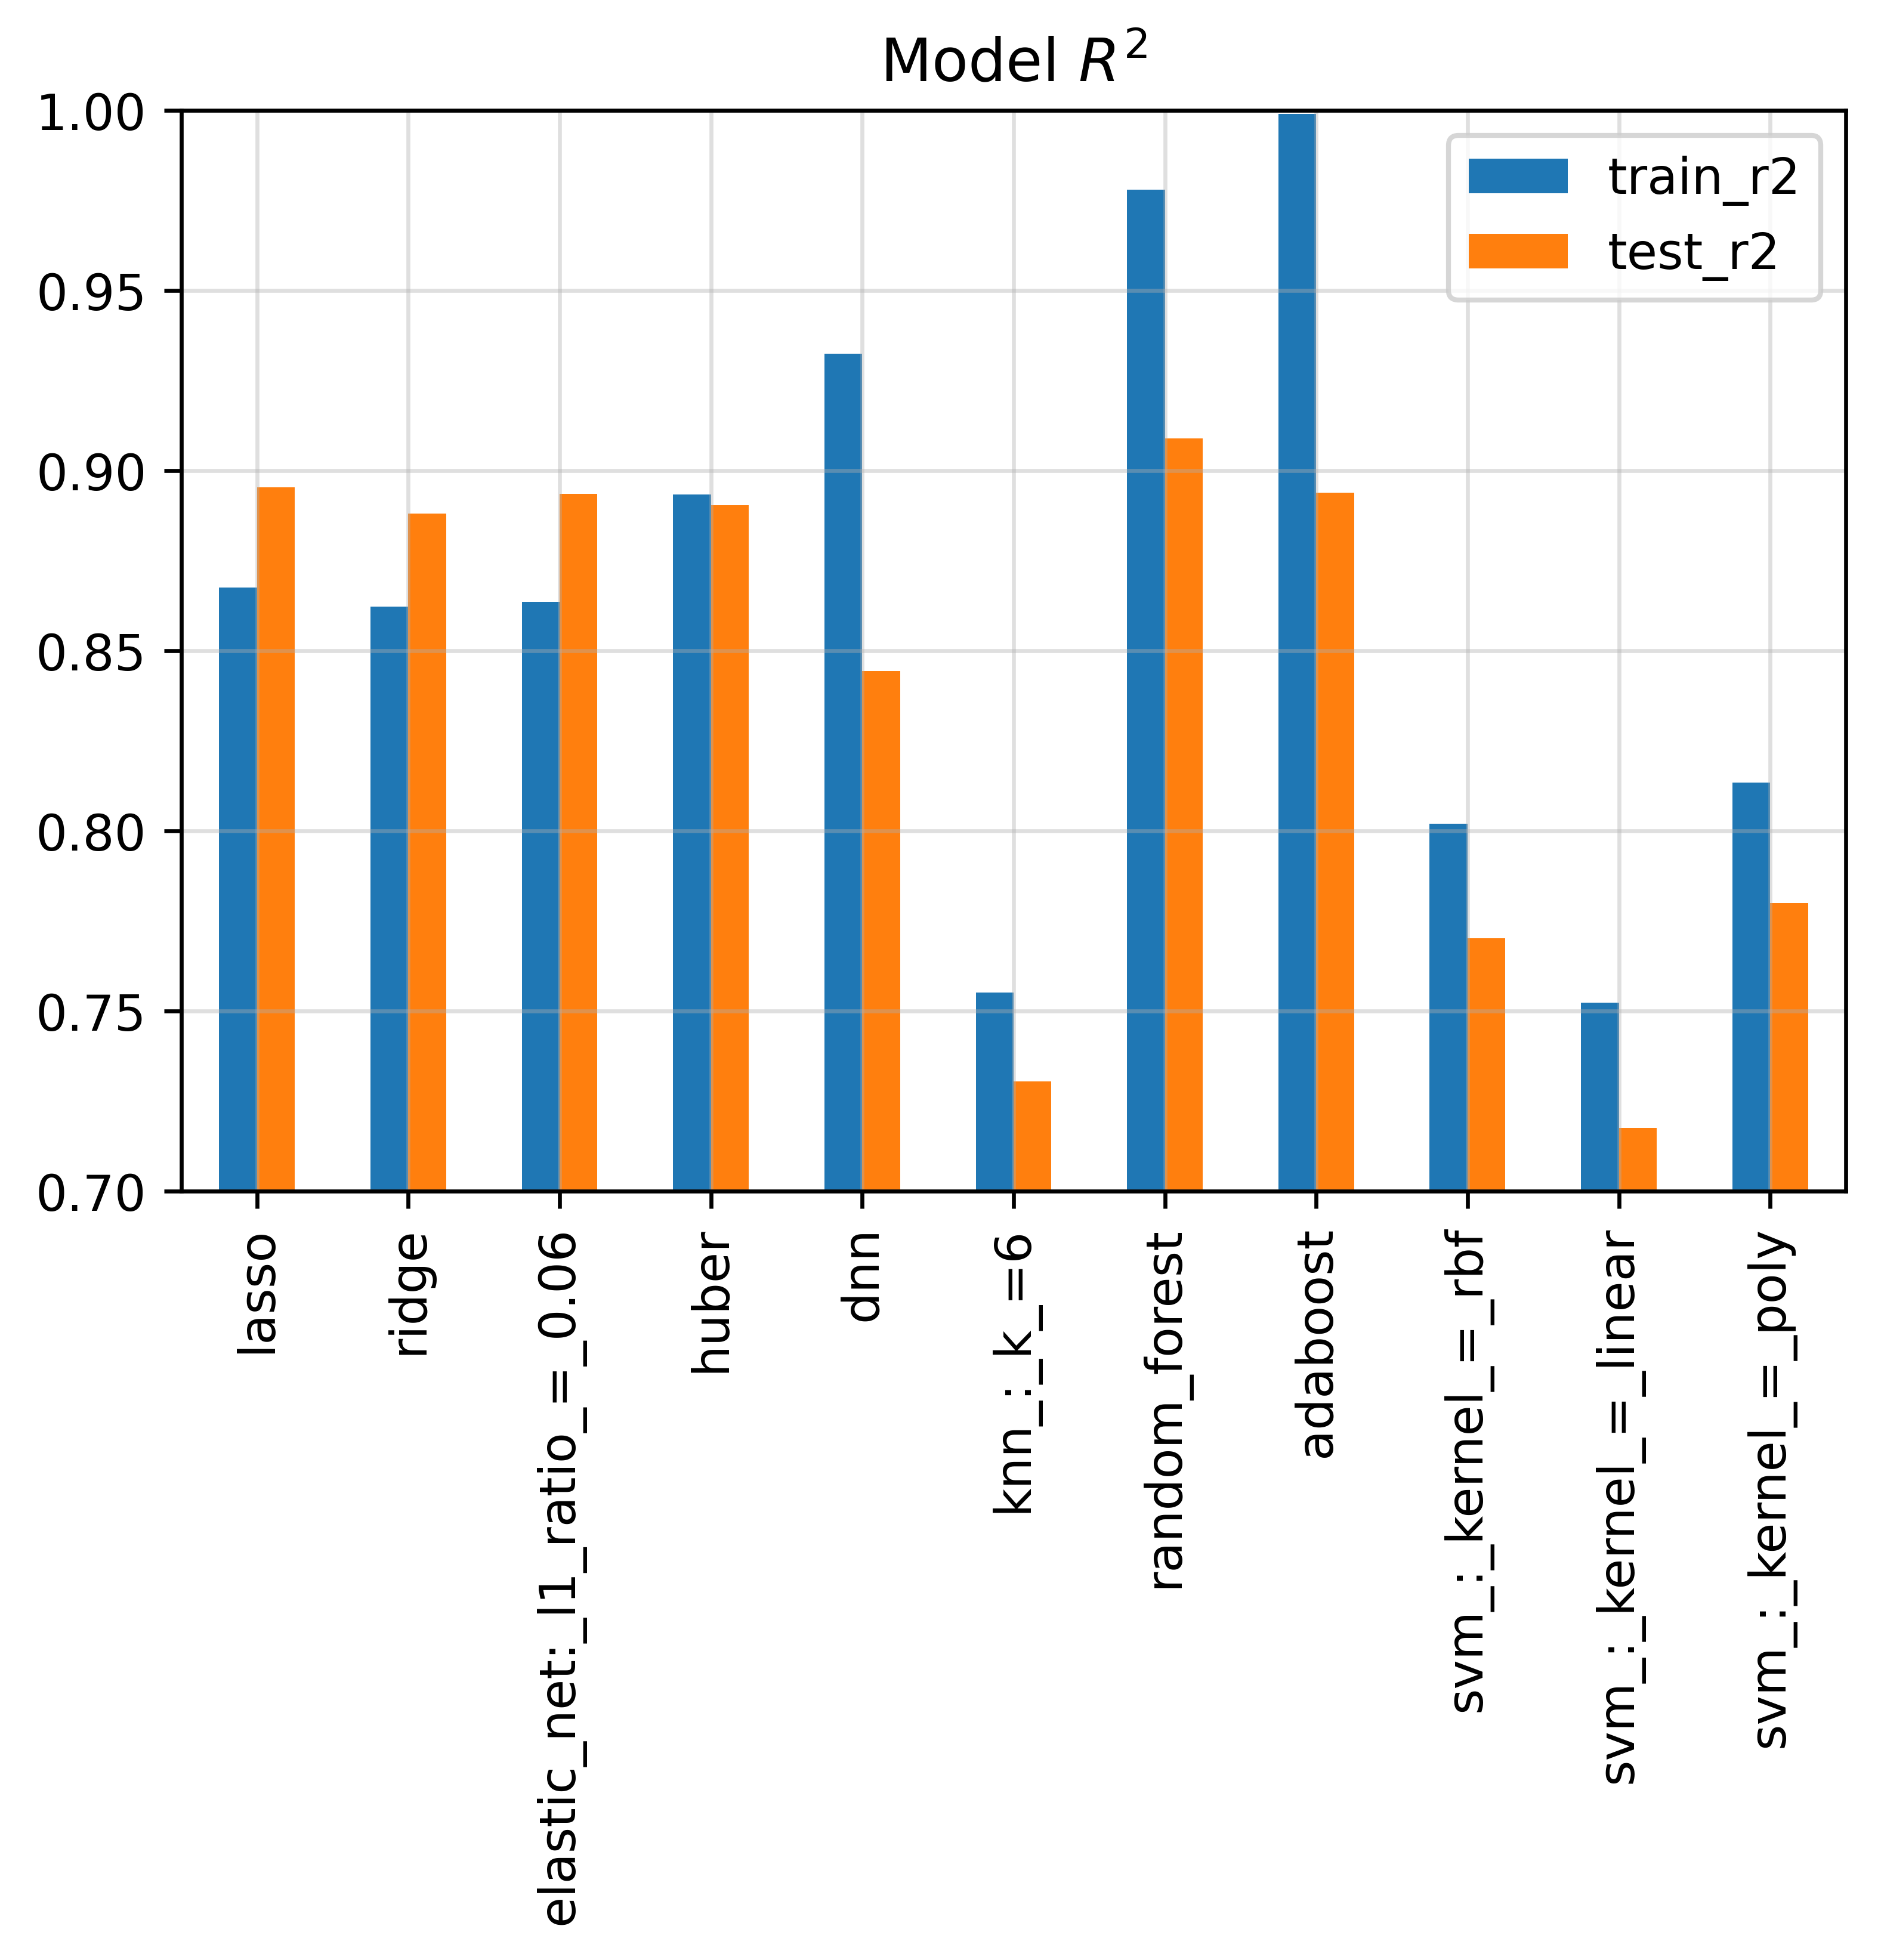

In [75]:
results[['train_r2','test_r2']][1:].plot(kind = 'bar',ylim = (0.7,1),title = "Model $R^2$")
plt.grid(alpha = 0.4)
print()

Examining the $R^2$ values for each model also outlines the good performance of the ensemble methods over regularized linear models. The deep neural network also had a very high training $R^2$, but waned significantly for the test data. The disparity is also present for the ensemble methods, but they still have the two highest test $R^2$ values of all methods and so are the best performers.

Across both the rmse and $R^2$ graphs we see that the adaboost method slightly outperformes the random forest model, so this project concludes that the adaboost method is the best for this dataset.